Check 

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
import scipy.stats as stats
from IPython.display import display
import warnings
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from graphviz import Digraph
import pandas as pd
from matplotlib import gridspec

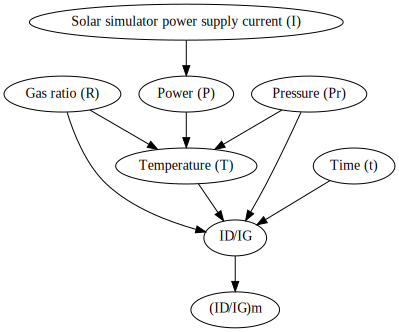

In [20]:
g = Digraph('Graphene optimization - stationary')
g.node('Gas ratio (R)')
g.node('Pressure (Pr)')
g.node('Temperature (T)')
g.node('Time (t)')
g.node('Solar simulator power supply current (I)')
g.node('Power (P)')
g.node('I_D/I_G', label='<I<sub>D</sub>/I<sub>G</sub>>')
g.node('Raman I_D/I_G', label='<(I<sub>D</sub>/I<sub>G</sub>)<sub>m</sub>>')
g.edge('Solar simulator power supply current (I)', 'Power (P)')
g.edge('Power (P)', 'Temperature (T)')
g.edge('Pressure (Pr)', 'Temperature (T)')
g.edge('Gas ratio (R)', 'Temperature (T)')
g.edge('Gas ratio (R)', 'I_D/I_G')
g.edge('Pressure (Pr)', 'I_D/I_G')
g.edge('Temperature (T)', 'I_D/I_G')
g.edge('Time (t)', 'I_D/I_G')
g.edge('I_D/I_G','Raman I_D/I_G')
g.render('Graphene optimization - stationary', format='png')
g

| Variable | Type | Values| 
|:---------|:--------------|:--------|
| $R$ | CH4:H2 gas ratio | [1:5,1:1] |
| $P$ | Pressure inside the reactor | [10, 50] Torr |
| $T$ | Temperature of the substrate | [1000, 1080] C|
| $A$ | Solar simulator power supply current to the xenon arc lamp | [100, 110] A|
| $t$ | Residence time from the growth process | [1, 10] min |

In [21]:
model_data = pd.read_table('data/data.txt', sep='\s+', index_col=0, skiprows=9, header=None, 
              names=['Experiment', 'Temperature', 'Pressure', 'Ratio', 'Time', 'Power', 'Intensity'])
model_data.head()

Temperature  Pressure  Ratio  Time  Power  Intensity
Experiment                                                      
1                  1007        10   0.25   5.0    100      0.814
2                  1023        10   0.25   5.0    102      0.800
3                  1016        10   0.25   5.0    101      0.802
4                  1038        10   0.25   5.0    104      0.887
5                  1060        10   0.25   5.0    106      0.169

In [22]:
X_obs = model_data[['Temperature', 'Pressure', 'Ratio', 'Time']].values
Y_obs = model_data.Intensity.values
# print(X_obs)
# print(Y_obs)
X_T_obs = model_data[['Pressure', 'Ratio', 'Power',]].values
T_obs = model_data.Temperature.values
# print(X_T_obs)
# print(T_obs)
# plt.figure(figsize=(10,8))
# ax = plt.axes(projection ="3d")
# ax.scatter(X_obs[:,0], X_obs[:,1], X_obs[:,2], X_obs[:,3], c=Y_obs, marker='s')
# plt.figure(figsize=(10,8))
# plt.scatter(X_obs[:,0], Y_obs)
# plt.xlabel('Temperature in (C)')
# plt.ylabel('$I_{D}$/$I_{G}$')
# plt.figure(figsize=(10,8))
# plt.scatter(X_obs[:,1], Y_obs)
# plt.xlabel('Gas ratio $CH_{4}$:$H_{2}$')
# plt.ylabel('$I_{D}$/$I_{G}$')
# plt.figure(figsize=(10,8))
# plt.scatter(X_obs[:,2], Y_obs)
# plt.xlabel('Pressurre in (Torr)')
# plt.ylabel('$I_{D}$/$I_{G}$')
# plt.figure(figsize=(10,8))
# plt.scatter(X_obs[:,3], Y_obs)
# plt.xlabel('Time in (s)')
# plt.ylabel('$I_{D}$/$I_{G}$')

# plt.figure(figsize=(10,8))
# ax = plt.axes(projection ="3d")
# ax.scatter(X_T_obs[:,0], X_T_obs[:,1], X_T_obs[:,2], c=T_obs, marker='s')
# plt.figure(figsize=(10,8))
# plt.scatter(X_T_obs[:,0], T_obs)
# plt.xlabel('Pressure (Torr)')
# plt.ylabel('$Temperature in (C)$')
# plt.figure(figsize=(10,8))
# plt.scatter(X_T_obs[:,1], T_obs)
# plt.xlabel('Gas ratio $CH_{4}$:$H_{2}')
# plt.ylabel('$Temperature in (C)$')
# plt.figure(figsize=(10,8))
# plt.scatter(X_T_obs[:,2], T_obs)
# plt.xlabel('Solar simulator power supply current (A)$')
# plt.ylabel('$Temperature in (C)$')


In [23]:
np.random.seed(123456) 
n = 100
d = 4
d_T = 3
X = X_obs
X_T = X_T_obs

# print(X)
Y = Y_obs[:,None]
Y_T = T_obs[:,None]
# print(Y)
# print(len(Y))
# x = np.zeros((n,4))
# x[:,0] = np.linspace(100, 110, n)
# x[:,1] = np.linspace(10, 50, n)
# x[:,2] = np.linspace(0.2, 1, n)
# x[:,3] = np.linspace(1, 10, n)
# print(x)
# print(X)
# print(Y)

In [24]:
def ei(m, sigma, ymin, psi=0.):
    u = (m - ymin) / sigma
    ei = (sigma * (u * stats.norm.cdf(u) + stats.norm.pdf(u)))
    ei[sigma <= 0.] = 0.
    return ei

In [25]:
def plot_min_and_argmin(d, gp, X_predict, n_samples=1000):
    """
    Plots histograms of the min and argmin of the function represented by the model gp.
    It takes ``n_samples`` samples from the posterior to do that evaluated at ``X_design``.
    """
    f_samples = gp.posterior_samples_f(X_predict, size=n_samples)[:, 0, :]
#     print(f_samples)
    min_f_samples = np.min(f_samples, axis=0)
#     print(min_f_samples)
    x_star_samples = X_predict[np.argmin(f_samples, axis=0), d]
#     print(x_star_samples)
    fig, ax = plt.subplots(dpi=100)
    ax.hist(min_f_samples, density=True, alpha=0.25)
    ax.set_xlabel('$f^*$')
    ax.set_ylabel('$p(f^*|\mathcal{D}_n)$')
    ax.set_xlim(0, np.max(min_f_samples))
    fig, ax = plt.subplots(dpi=100)
    ax.hist(x_star_samples, density=True, alpha=0.25)
    ax.set_xlabel('$x^*$')
    ax.set_ylabel('$p(x^*|\mathcal{D}_n)$')
    return fig

In [26]:
def minimize_w_noise_1d(gp, X_predict, d, ϵ, alpha=ei, psi=0., max_it=6, plot_epistemic=True):
    af_all = []
    for k in range(max_it):
        mn_p, v_p = gp.predict(X_predict)
        σ_p = np.sqrt(v_p - gp.likelihood.variance)
        l_p = mn_p - 2 * σ_p
        u_p = mn_p + 2 * σ_p
#         print('X_predict')
#         print(X_predict)
        y_smoothed = gp.predict(gp.X)[0]
#         print('y_smoothed')
#         print(y_smoothed)
        mn_star = y_smoothed.min()
#         print('mn_star')
#         print(mn_star)
        af_values = alpha(mn_p, σ_p, mn_star, psi=psi)
#         print('af_values')
#         print(af_values)
        i = np.argmax(af_values)
#         print('i')
#         print(i)
        af_all.append(af_values[i])
        if np.max(af_values)>ϵ:
            #         print(X_design[i:(i+1)])
            X = np.vstack([gp.X, X_predict[i:(i+1)]])
            Y = np.vstack([gp.Y, [mn[i, :]]])
            gp.set_XY(X, Y)
#             print('gp.X and gp.Y')
#             print(gp.X)
#             print(gp.Y)
#             gp.optimize()
            print(X_predict[i,d])
            print(X_predict)
            print(np.max(af_values))
            fig, ax = plt.subplots(dpi=100)
            ax.plot(gp.X[:,d], gp.Y, 'kx', markersize=10, markeredgewidth=2)
            if d==0:
                x_label = 'Temperature (C)'
            elif d==1:
                x_label = 'Pressure (Torr)'
            elif d==2:
                x_label = '$CH_{4}$:$H_{2}$ ratio'
            else:
                x_label = 'Time (min)'
            ax.set_xlabel(x_label)
            ax.set_ylabel('$I_{D}$/$I_{G}$')
    #         print(X[:,i])
            ax.plot(X_predict[:,d], mn)
            ax.fill_between(X_predict[:,d].flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
            ax.set_ylim(0, np.max(u.flatten() + 2.0 * σ_n))
            ax2 = ax.twinx()
            ax2.plot(X_predict[:,d], af_values, color=sns.color_palette()[1])
    # #         print(X_design)
            plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
            ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
            ax2.plot(X_predict[:,d][i] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                     linewidth=1)
            if plot_epistemic:
                fig = plot_min_and_argmin(d, gp, X_predict)
    return af_all

## Gaussian process

A Gaussian process (GP) is a generalization of a multivariate Gaussian distribution to
*infinite* dimensions.
Mathematically, we write:
\begin{equation}
f(\cdot) \sim \mbox{GP}\left(m(\cdot), k(\cdot, \cdot) \right),
\end{equation}
where 
$m:\mathbb{R}^d \rightarrow \mathbb{R}$ is the *mean function* and 
$k:\mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ is the *covariance function*.
So, compared to a multivariate normal we have:

+ A random function $f(\cdot)$ instead of a random vector $\mathbf{x}$.
+ A mean function $m(\cdot)$ instead of a mean vector $\boldsymbol{\mu}$.
+ A covariance function $k(\cdot,\cdot)$ instead of a covariance matrix $\mathbf{\Sigma}$.

+ Let $\mathbf{x}_{1:n}=\{\mathbf{x}_1,\dots,\mathbf{x}_n\}$ be $n$ points in $\mathbb{R}^d$.
+ Let $\mathbf{f}\in\mathbb{R}^n$ be the outputs of $f(\cdot)$ on each one of the elements of $\mathbf{x}_{1:n}$, i.e.,
$$
\mathbf{f} =
\left(
\begin{array}{c}
f(\mathbf{x}_1)\\
\vdots\\
f(\mathbf{x}_n)
\end{array}
\right).
$$
+ The fact that $f(\cdot)$ is a GP with mean and covariance function $m(\cdot)$ and $k(\cdot,\cdot)$, respectively, *means* that the vector of outputs $\mathbf{f}$ at
the arbitrary inputs in $\mathbf{X}$ is the following multivariate-normal:
$$
\mathbf{f} | \mathbf{x}_{1:n}, m(\cdot), k(\cdot, \cdot) \sim \mathcal{N}\left(\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) \right),
$$
with mean vector:
$$
\mathbf{m}(\mathbf{x}_{1:n}) =
\left(
\begin{array}{c}
m(\mathbf{x}_1)\\
\vdots\\
m(\mathbf{x}_n)
\end{array}
\right),
$$
and covariance matrix:
$$
\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) = \left(
\begin{array}{ccc}
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1, \mathbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\mathbf{x}_n, \mathbf{x}_1) & \dots & k(\mathbf{x}_n, \mathbf{x}_n)
\end{array}
\right).
$$
$$
p(f(\cdot)|\mathcal{D}) \propto p(\mathcal{D}|f(\cdot)) p(f(\cdot)),
$$
where $p(f(\cdot))$ is the prior, $p(f(\cdot)|\mathcal{D})$ the posterior and $p(\mathcal{D}|f(\cdot))$ is the likelihood of the data.
$$
p(y|\mathbf{x},\mathcal{D}_n) = \mathcal{N}(y|m_n(\mathbf{x}), \sigma_n^2(\mathbf{x}) + \sigma^2),
$$
where $\sigma_n^2(\mathbf{x}) = k_n(\mathbf{x},\mathbf{x})$, i.e., the posterior variance for $f(\mathbf{x})$.

$$
r=\sqrt{\sum_{i=1}^{\text {input_dim }} \frac{\left(x_{i}-y_{i}\right)^{2}}{\ell_{i}^{2}}}
$$
$$
k(r)=\sigma^{2}\left(1+\sqrt{5} r+\frac{5}{3} r^{2}\right) \exp (-\sqrt{5} r)
$$

## L-BFGS optimization 
optimization for these parameters $ρ$: Matern 52.lengthscale (4 parameters), $η$: Matern 52 variance, $σ_n$: Gaussian noise variance


Optimization restart 1/50, f = -5.17442398794077
Optimization restart 2/50, f = 40.42748486035609
Optimization restart 3/50, f = 40.427484860422595
Optimization restart 4/50, f = -5.174423987305595
Optimization restart 5/50, f = -5.17442398770654
Optimization restart 6/50, f = 40.427484858855266
Optimization restart 7/50, f = 40.42748485999943
Optimization restart 8/50, f = -5.174423987086641
Optimization restart 9/50, f = 40.42748482831105
Optimization restart 10/50, f = 38.606784304249715
Optimization restart 11/50, f = 40.42748488553023
Optimization restart 12/50, f = 51.43820248561788
Optimization restart 13/50, f = -5.1744239835623915
Optimization restart 14/50, f = -5.174423987709247
Optimization restart 15/50, f = -5.174423987546888
Optimization restart 16/50, f = 91.30310090343556
Optimization restart 17/50, f = 41.86517322797216


 /opt/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 18/50, f = -5.1744239877239835
Optimization restart 19/50, f = 17.000662002808923


 /opt/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 20/50, f = 8.142583924082821
Optimization restart 21/50, f = 1.5055910940579835
Optimization restart 22/50, f = -5.174423987390917
Optimization restart 23/50, f = 40.42747026907519
Optimization restart 24/50, f = 40.427484864320135
Optimization restart 25/50, f = 40.427483937462554
Optimization restart 26/50, f = -5.1744239877314016
Optimization restart 27/50, f = 76.64066535005561
Optimization restart 28/50, f = 40.42748486005528
Optimization restart 29/50, f = -5.174423988154238
Optimization restart 30/50, f = -5.1744239877588925
Optimization restart 31/50, f = -5.174423987075123
Optimization restart 32/50, f = 40.42748485975833
Optimization restart 33/50, f = -0.7558690797634355
Optimization restart 34/50, f = 40.42748485967855
Optimization restart 35/50, f = -5.174423987276548
Optimization restart 36/50, f = -5.174423987396736
Optimization restart 37/50, f = 40.427484859967926
Optimization restart 38/50, f = -5.174423987326357
Optimization restart 39/50, f = 40

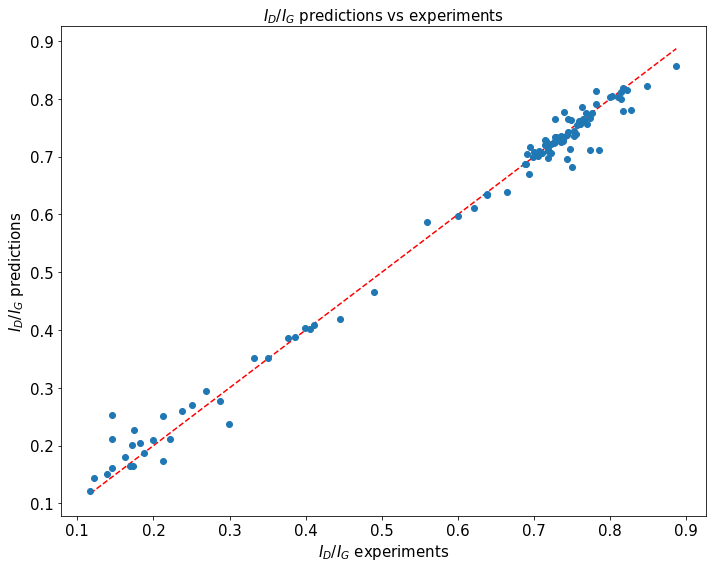

In [27]:
# define kernel
ρ = [30, 25, 0.15, 1.67]
# ρ_T = [290, 20767, 194]
η = 0.39
# η_T = 121600
σ_n = 0.05 #0.039
σ_n_ = σ_n #
# σ_n_T = 4
k = GPy.kern.Matern52(input_dim = 4, lengthscale = ρ, variance = η, ARD=True) 
# k_T = GPy.kern.Matern52(input_dim = 3, lengthscale = ρ_T, variance = η_T, ARD=True) 
# create simple GP model
gp = GPy.models.GPRegression(X, Y, k)
# gp_T = GPy.models.GPRegression(X_T, Y_T, k_T)
# optimize
gp.likelihood.variance.constrain_fixed(σ_n**2)
# gp_T.likelihood.variance.constrain_fixed(σ_n_T**2)
gp.optimize('lbfgs', max_iters=1000, messages=True, max_f_eval = 1000)
gp.optimize_restarts(num_restarts = 50, robust=True)
# gp_T.optimize('lbfgs', max_iters=1000, messages=True, max_f_eval = 1000)
# gp_T.optimize_restarts(num_restarts = 50, robust=True)
# print(sigma_noise)
# print(gp)
ls = gp.Mat52.lengthscale
# ls_T = gp_T.Mat52.lengthscale
σ_n = np.sqrt(gp.Gaussian_noise.variance[0])
# σ_n_T = np.sqrt(gp_T.Gaussian_noise.variance[0])
print('σ_n Gaussian noise variance')
print(σ_n)
# print(σ_n_T)
η = gp.Mat52.variance[0]
# η_T = gp_T.Mat52.variance[0]
print('η Matern 52 variance')
print(η)
# print(η_T)
ρ = [ls[0], ls[1], ls[2], ls[3]]
# ρ_T = [ls_T[0], ls_T[1], ls_T[2]]
print('ρ Matern 52.lengthscale')
print(ρ)
# print(ρ_T)
Y_m, Y_v = gp.predict(X, full_cov=False) 
# Y_m_T, Y_v_T = gp_T.predict(X_T, full_cov=False) 
error_m = np.sqrt(mean_squared_error(Y, Y_m))
# error_m_T = np.sqrt(mean_squared_error(Y_T, Y_m_T))
fig = plt.figure(figsize = (10, 8))
ax  = plt.subplot(111)
x_error = np.linspace(np.min(Y), np.max(Y), 100)
ax.plot(x_error, x_error, 'r--', label='$x=y$')
ax.plot(Y, Y_m, 'o')
ax.set_title('$I_{D}$/$I_{G}$ predictions vs experiments', fontsize=15)
ax.set_xlabel('$I_{D}$/$I_{G}$ experiments', fontsize=15)
ax.set_ylabel('$I_{D}$/$I_{G}$ predictions', fontsize=15)
ax.tick_params( labelsize=15 )
fig.tight_layout()
print('mean squared error (Intensity ratio)')
print(error_m)
# fig = plt.figure(figsize = (10, 8))
# ax  = plt.subplot(111)
# x_error_T = np.linspace(np.min(T_obs), np.max(T_obs), 100)
# ax.plot(x_error_T, x_error_T, 'r--', label='$x=y$')
# ax.plot(T_obs, Y_m_T, 'o')
# ax.set_title('Temperature predictions vs experiments', fontsize=15)
# ax.set_xlabel('Temperature (C) experiments', fontsize=15)
# ax.set_ylabel('Temperature (C) predictions', fontsize=15)
# ax.tick_params( labelsize=15 )
# fig.tight_layout()
# print('mean squared error')
# print(error_m_T)


0.38094762352248435
0.19158264304426864
0.1001650118459089
0.07518209957586633
mean squared error (Intensity ratio)
0.02439553053131408


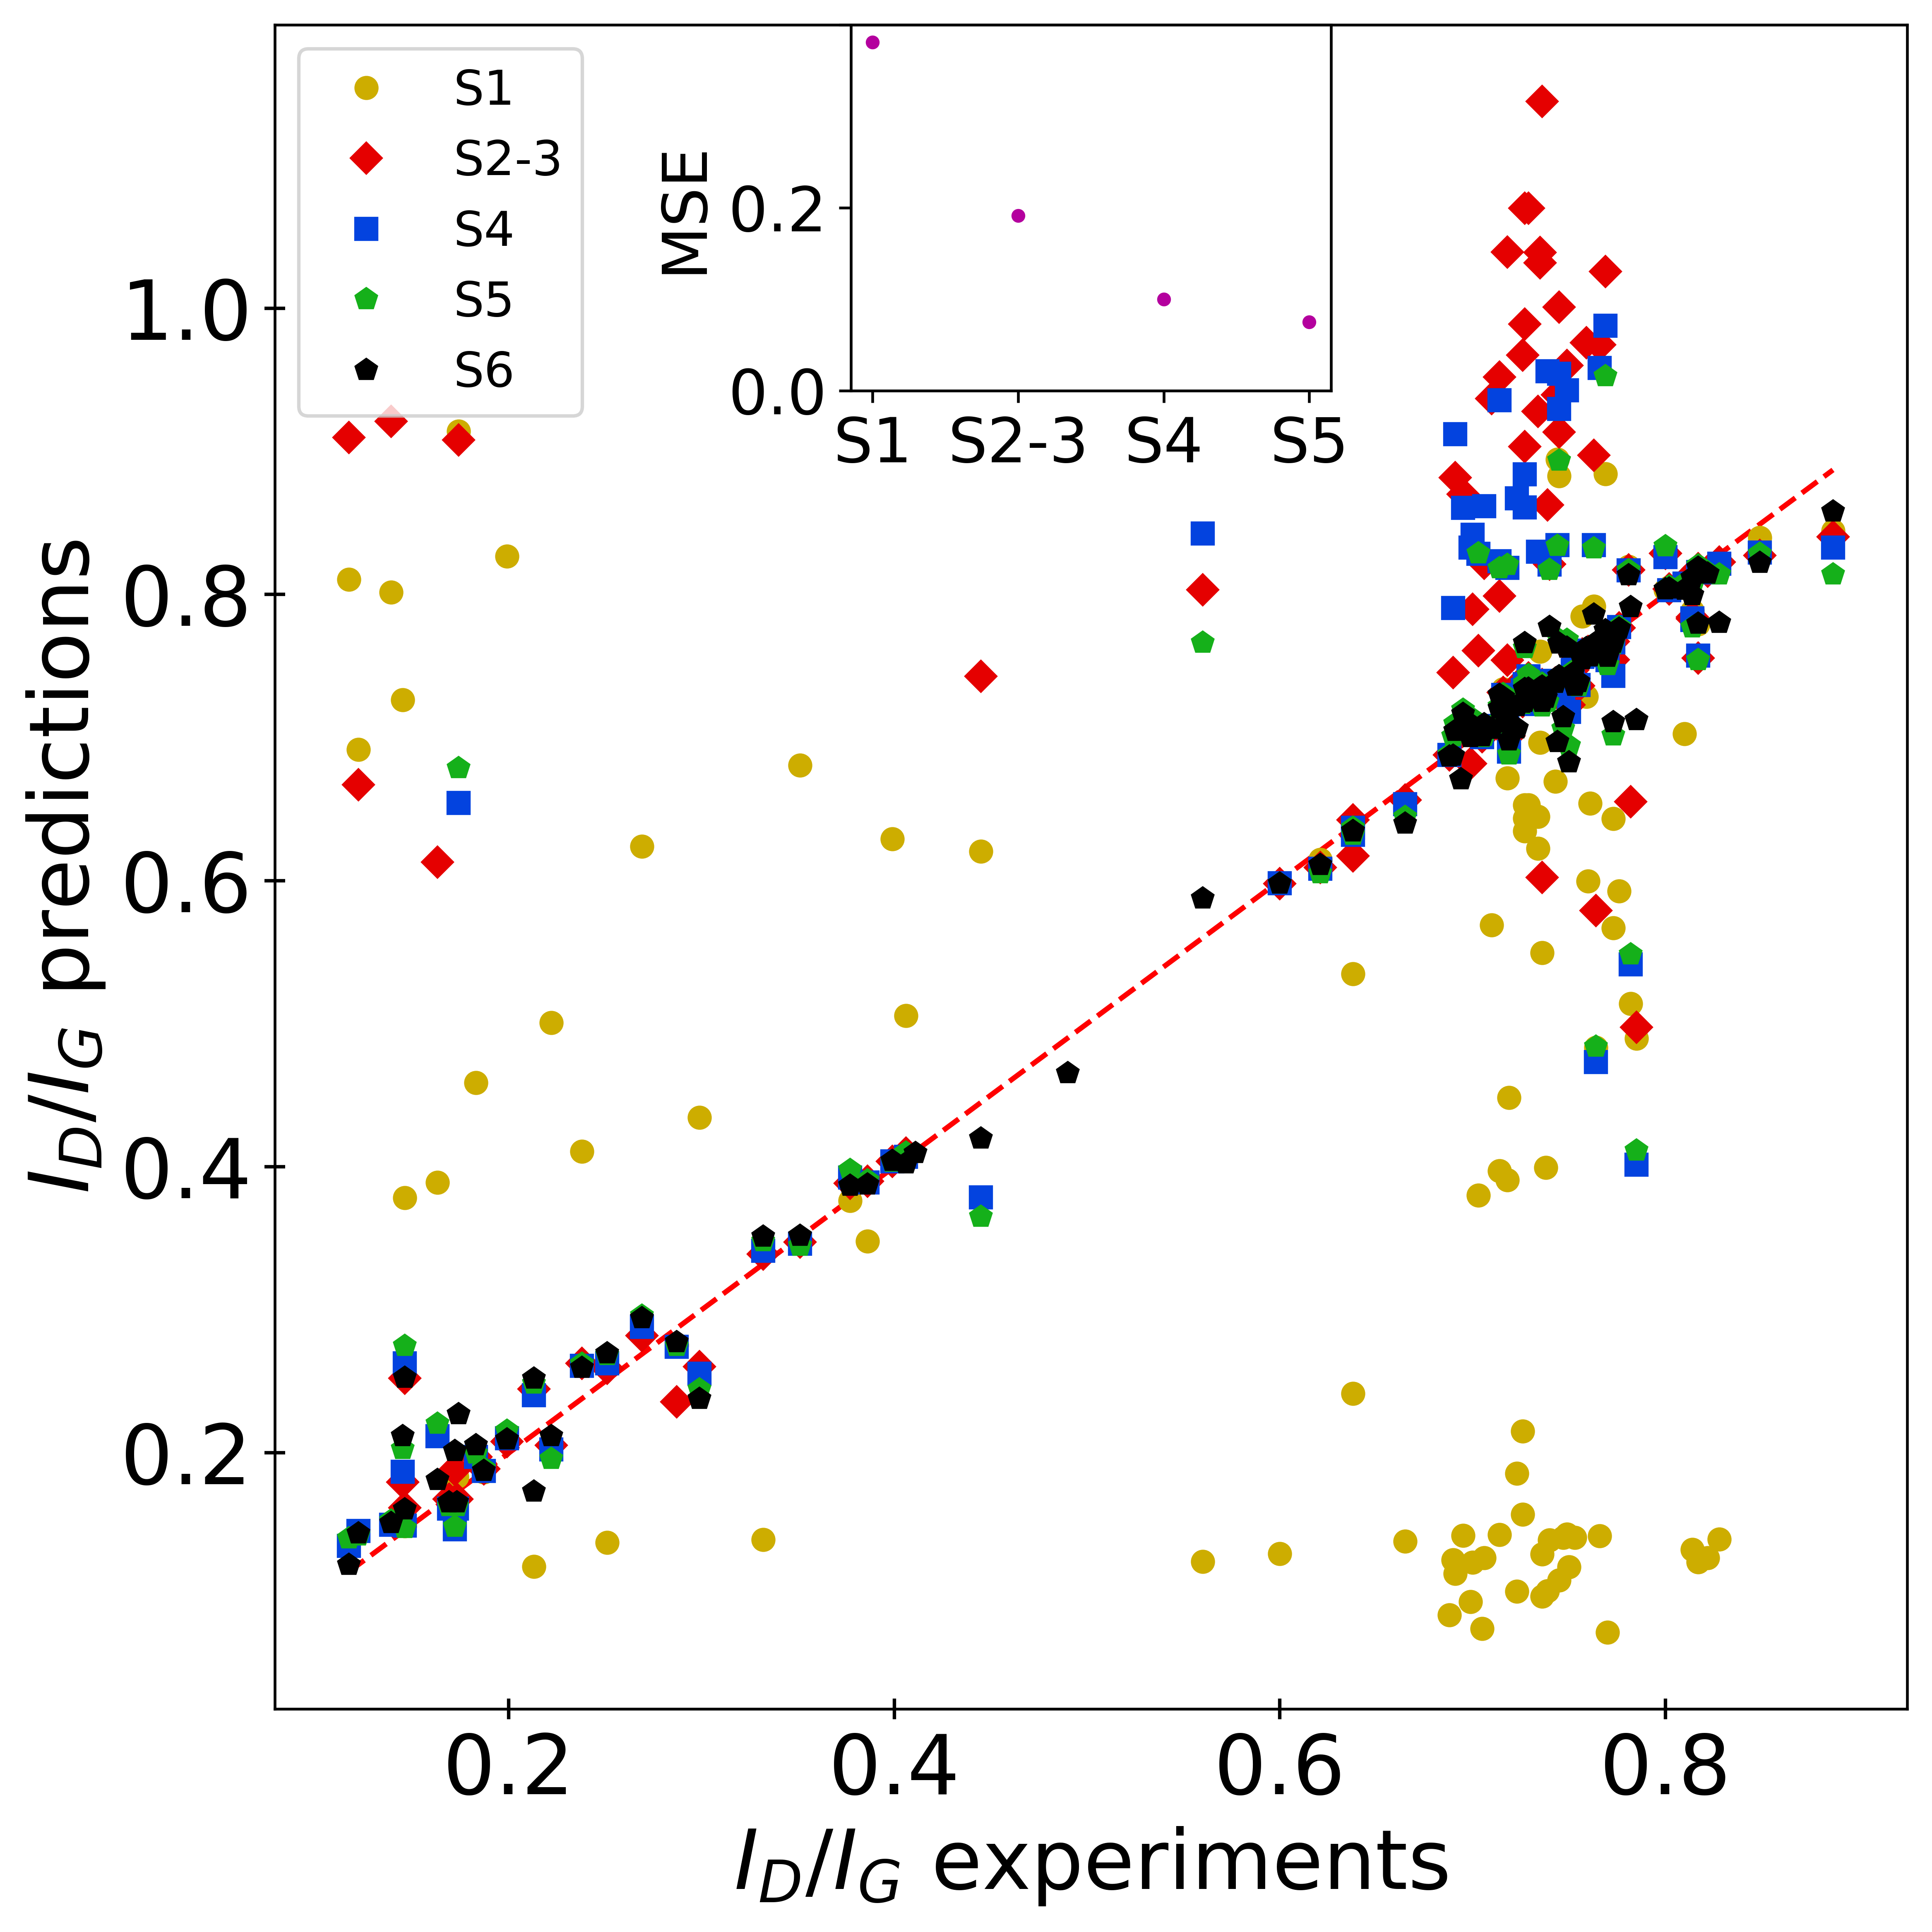

In [28]:
Y_p_0 = (np.array(pd.read_excel('data/surrogate model prediction_0.xlsx', sheet_name=0, header=None, index_col=None))).flatten()
Y_p_1 = (np.array(pd.read_excel('data/surrogate model prediction_1.xlsx', sheet_name=0, header=None, index_col=None))).flatten()
Y_p_2 = (np.array(pd.read_excel('data/surrogate model prediction_2.xlsx', sheet_name=0, header=None, index_col=None))).flatten()
Y_p_3 = (np.array(pd.read_excel('data/surrogate model prediction_3.xlsx', sheet_name=0, header=None, index_col=None))).flatten()
a = np.zeros(4)
x = [0, 1, 2, 3]
fig, ax = plt.subplots(figsize=(8,8), dpi=600)
plt.rc('font', size=14) 
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
ax  = plt.subplot(111)
x_error = np.linspace(np.min(Y), np.max(Y), 100)
ax.plot(x_error, x_error, 'r--')
ax.plot(Y[0:105], Y_p_0[0:105], color='#CDAD00', marker='o', linestyle='none', label='S1')
a[0] = np.sqrt(mean_squared_error(Y_m[0:105], Y_p_0[0:105]))
print(a[0])
ax.plot(Y[0:105], Y_p_1[0:105], color='#E50000', marker='D', linestyle='none', label='S2-3')
a[1] = np.sqrt(mean_squared_error(Y_m[0:105], Y_p_1[0:105]))
print(a[1])
ax.plot(Y[0:105], Y_p_2[0:105], color='#0343DF', marker='s', linestyle='none', label='S4')
a[2] = np.sqrt(mean_squared_error(Y_m[0:105], Y_p_2[0:105]))
print(a[2])
ax.plot(Y[0:105], Y_p_3[0:105], color='#15B01A', marker='p', linestyle='none', label='S5')
a[3] = np.sqrt(mean_squared_error(Y_m[0:105], Y_p_3[0:105]))
print(a[3])
ax.plot(Y, Y_m, color='#000000', marker='p', linestyle='none', label='S6')
ax.set_xlabel('$I_{D}$/$I_{G}$ experiments', fontsize=24)
ax.set_ylabel('$I_{D}$/$I_{G}$ predictions', fontsize=24)
ax.tick_params(direction='inout', length=6, width=1, colors='k',
               grid_color='r', grid_alpha=0.5, labelsize =24)
fig.tight_layout()
# plt.legend(bbox_to_anchor=(0.81, 0.76))
plt.legend()
print('mean squared error (Intensity ratio)')
print(error_m)
# ax.set_ylim([0, 1.2])
# ax.set_xlim([0, 1.0])

# ax1 = fig.add_subplot(332) 
# x_error = np.linspace(np.min(Y), np.max(Y), 100)
# ax1.plot(x_error, x_error, 'r--')
# ax1.plot(Y, Y_m, color='#15B01A', marker='p', linestyle='none', label='Refined set 3')
# ax1.tick_params(labelsize=18)
# ax1.xaxis.set_label_position('top')
# ax1.tick_params(axis="x",direction="in", pad=-22)
# ax1.tick_params(axis='y', colors='#8C000F')
# ax1.tick_params(axis='x', colors='#8C000F')
# xticks = ax1.xaxis.get_major_ticks()
# xticks[0].label1.set_visible(False)
# yticks = ax1.yaxis.get_major_ticks()
# yticks[0].label1.set_visible(False)
# ax1.set_ylim([-0.1, 1.2])
# ax1.set_xlim([-0.1, 1.2])
# # fig.tight_layout()
# # ax1.legend(loc='center right', prop={'size': 9})
# print('mean squared error (Intensity ratio)')
# print(error_m)

ax2 = fig.add_subplot(432) 
ax2.tick_params(axis='x', labelsize= 18)
ax2.tick_params(axis='y', labelsize= 18)
# ax2.set_xscale('log')
plt.ylabel('MSE', fontsize=18)
my_xticks = ['S1', 'S2-3', 'S4', 'S5']
ax2.set_ylim([0, 0.4])
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.xticks(x, my_xticks)
ax2.plot(x,a, color='#B4009E', marker='.', linestyle='none')

Having the posterior mean and variance, we can derive 95\% predictive intervals for $f(x^*)$ and $y^*$.
For $f(x^*)$ these are:
$$
m_n(\mathbf{x}^*)) - 2\sigma_n(\mathbf{x}^*) \le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sigma_n(\mathbf{x}^*).
$$
Let's superimpose our predictive error bar.
This is:
$$
m_n(\mathbf{x}^*)) - 2\sqrt{\sigma_n^2(\mathbf{x}^*)+\sigma^2}\le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sqrt{\sigma_n^2(\mathbf{x}) + \sigma^2}.
$$

### Sequential Information Acquisition for Optimization
$$
\mathbf{x}^* = \arg\min_{\mathbf{x}}f(\mathbf{x}).
$$
under the assumption that:
+ we can evaluate $f(\mathbf{x})$ at any $\mathbf{x}$;
+ evaluating $f(\mathbf{x})$ takes a lot of time/money;
+ we cannot evaluate the gradient $\nabla f(\mathbf{x})$;
+ the dimensionality of $\mathbf{x}$ is not very high.

###  Algorithm
+ We start with an initial data set consiting of $n_0$ input-output observations:
$$
\mathcal{D}_{n_0} = \left(\mathbf{x}_{1:n_0}, \mathbf{y}_{1:n_0}\right).
$$

+ For $n=n_0,n_0+1,\dots$, we start do the following:
    - We use the current dataset to quantify our state of knowledge about $f(\mathbf{x})$.
    For example, we can use Gaussian process to obtain the predictive distribution:
        $$
        f(\cdot) | \mathcal{D}_{n_0} \sim p(f(\cdot)|\mathcal{D}_{n_0}).
        $$
    - Then we pick the *most important* point to evaluate next by looking at maximizing an *acquisition function*
    $a_{n_0}(\mathbf{x})$ which depends on our current state of knowledge.
    $$
    \mathbf{x}_{n+1} = \arg\max a_{n}(\mathbf{x}).
    $$
    That is, we pick the point with the maximum value or the maximum information.
    - If maximum value of the acquisition function is smaller than a threshold, e.g., if $a_n(\mathbf{x}) \le \epsilon$ for some $\epsilon > 0$, then we STOP.
    - Otheweise, we evaluate the function at the selected $\mathbf{x}_{n+1}$ to obtain:
    $$
    y_n = f(\mathbf{x}_n).
    $$
    This would entain either running a simulation or doing an experiment.
    - We augment our original data set with the new observation:
    $$
    \mathcal{D}_{n+1} = \left((\mathbf{x}_{1:n},\mathbf{x}_n), (\mathbf{y}_{1:n},y_n)\right).
    $$
    - We use Bayes' rule to update our state of knowledge:
    $$
    f(\cdot)|\mathcal{D}_{n+1} \sim p(f(\cdot)|\mathcal{D}_{n+1}) \propto p(y_{n+1}|x_{n+1}, f(\cdot))p(f(\cdot)|\mathcal{D}_{n}).
    $$
    - If we have run out of evaluation budget, we STOP. Otherwise, we continue the loop.
+ At this point, we report our current state of knowledge about the minimum of the function.
That is, we can find the index of the evaluation corresponding to the observed minimum:
$$
i^* = \arg\min_{1\le i\le n} y_i,
$$
and say that the minimum was $y_{i^*}$ and the location of the minimum is $\mathbf{x}_{i^*}$.
Alternatively, and in particular if our optimizatioin budget is low and quantify our epistemic uncertainty about the location of the minimum

## Expected improvment with noise

The arguments here are as in the previous section about the probability of improvement.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best observed point $m_n^*$.
It is:
$$
I_n(\mathbf{x}, f(\mathbf{x})) =
\begin{cases}
0,&\;\text{if}\;f(\mathbf{x}) \le m_n^*,\\
f(\mathbf{x}) - m_n^*,&\;\text{otherwise},
\end{cases}
$$
and this conditional of $y$, i.e., $f(\mathbf{x})$ is a random variable conditioned on $y$.
Taking the expectation over $y$ would give you:
$$
\operatorname{EI}_n(\mathbf{x}) = \frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\Phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right)
+ \phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right).
$$

In [29]:
data_red_temp = (np.array(pd.read_excel('data/data temp red.xlsx', sheet_name=0, header=None, index_col=0)))
data_black_temp = (np.array(pd.read_excel('data/data temp black.xlsx', sheet_name=0, header=None, index_col=0)))
data_purple_time = (np.array(pd.read_excel('data/data time purple.xlsx', sheet_name=0, header=None, index_col=0)))
data_black_time = (np.array(pd.read_excel('data/data time black.xlsx', sheet_name=0, header=None, index_col=0)))
data_darkblue_pressure = (np.array(pd.read_excel('data/data pressure dark blue.xlsx', sheet_name=0, header=None, index_col=0)))
data_lightblue_pressure = (np.array(pd.read_excel('data/data pressure light blue.xlsx', sheet_name=0, header=None, index_col=0)))
data_black_pressure = (np.array(pd.read_excel('data/data pressure black.xlsx', sheet_name=0, header=None, index_col=0)))
data_darkgreen_ratio = (np.array(pd.read_excel('data/data ratio dark green.xlsx', sheet_name=0, header=None, index_col=0)))
data_lightgreen_ratio = (np.array(pd.read_excel('data/data ratio light green.xlsx', sheet_name=0, header=None, index_col=0)))
data_black_ratio = (np.array(pd.read_excel('data/data ratio black.xlsx', sheet_name=0, header=None, index_col=0)))
data_gold = (np.array(pd.read_excel('data/data gold.xlsx', sheet_name=0, header=None, index_col=0)))
data_orange = (np.array(pd.read_excel('data/data orange.xlsx', sheet_name=0, header=None, index_col=0)))

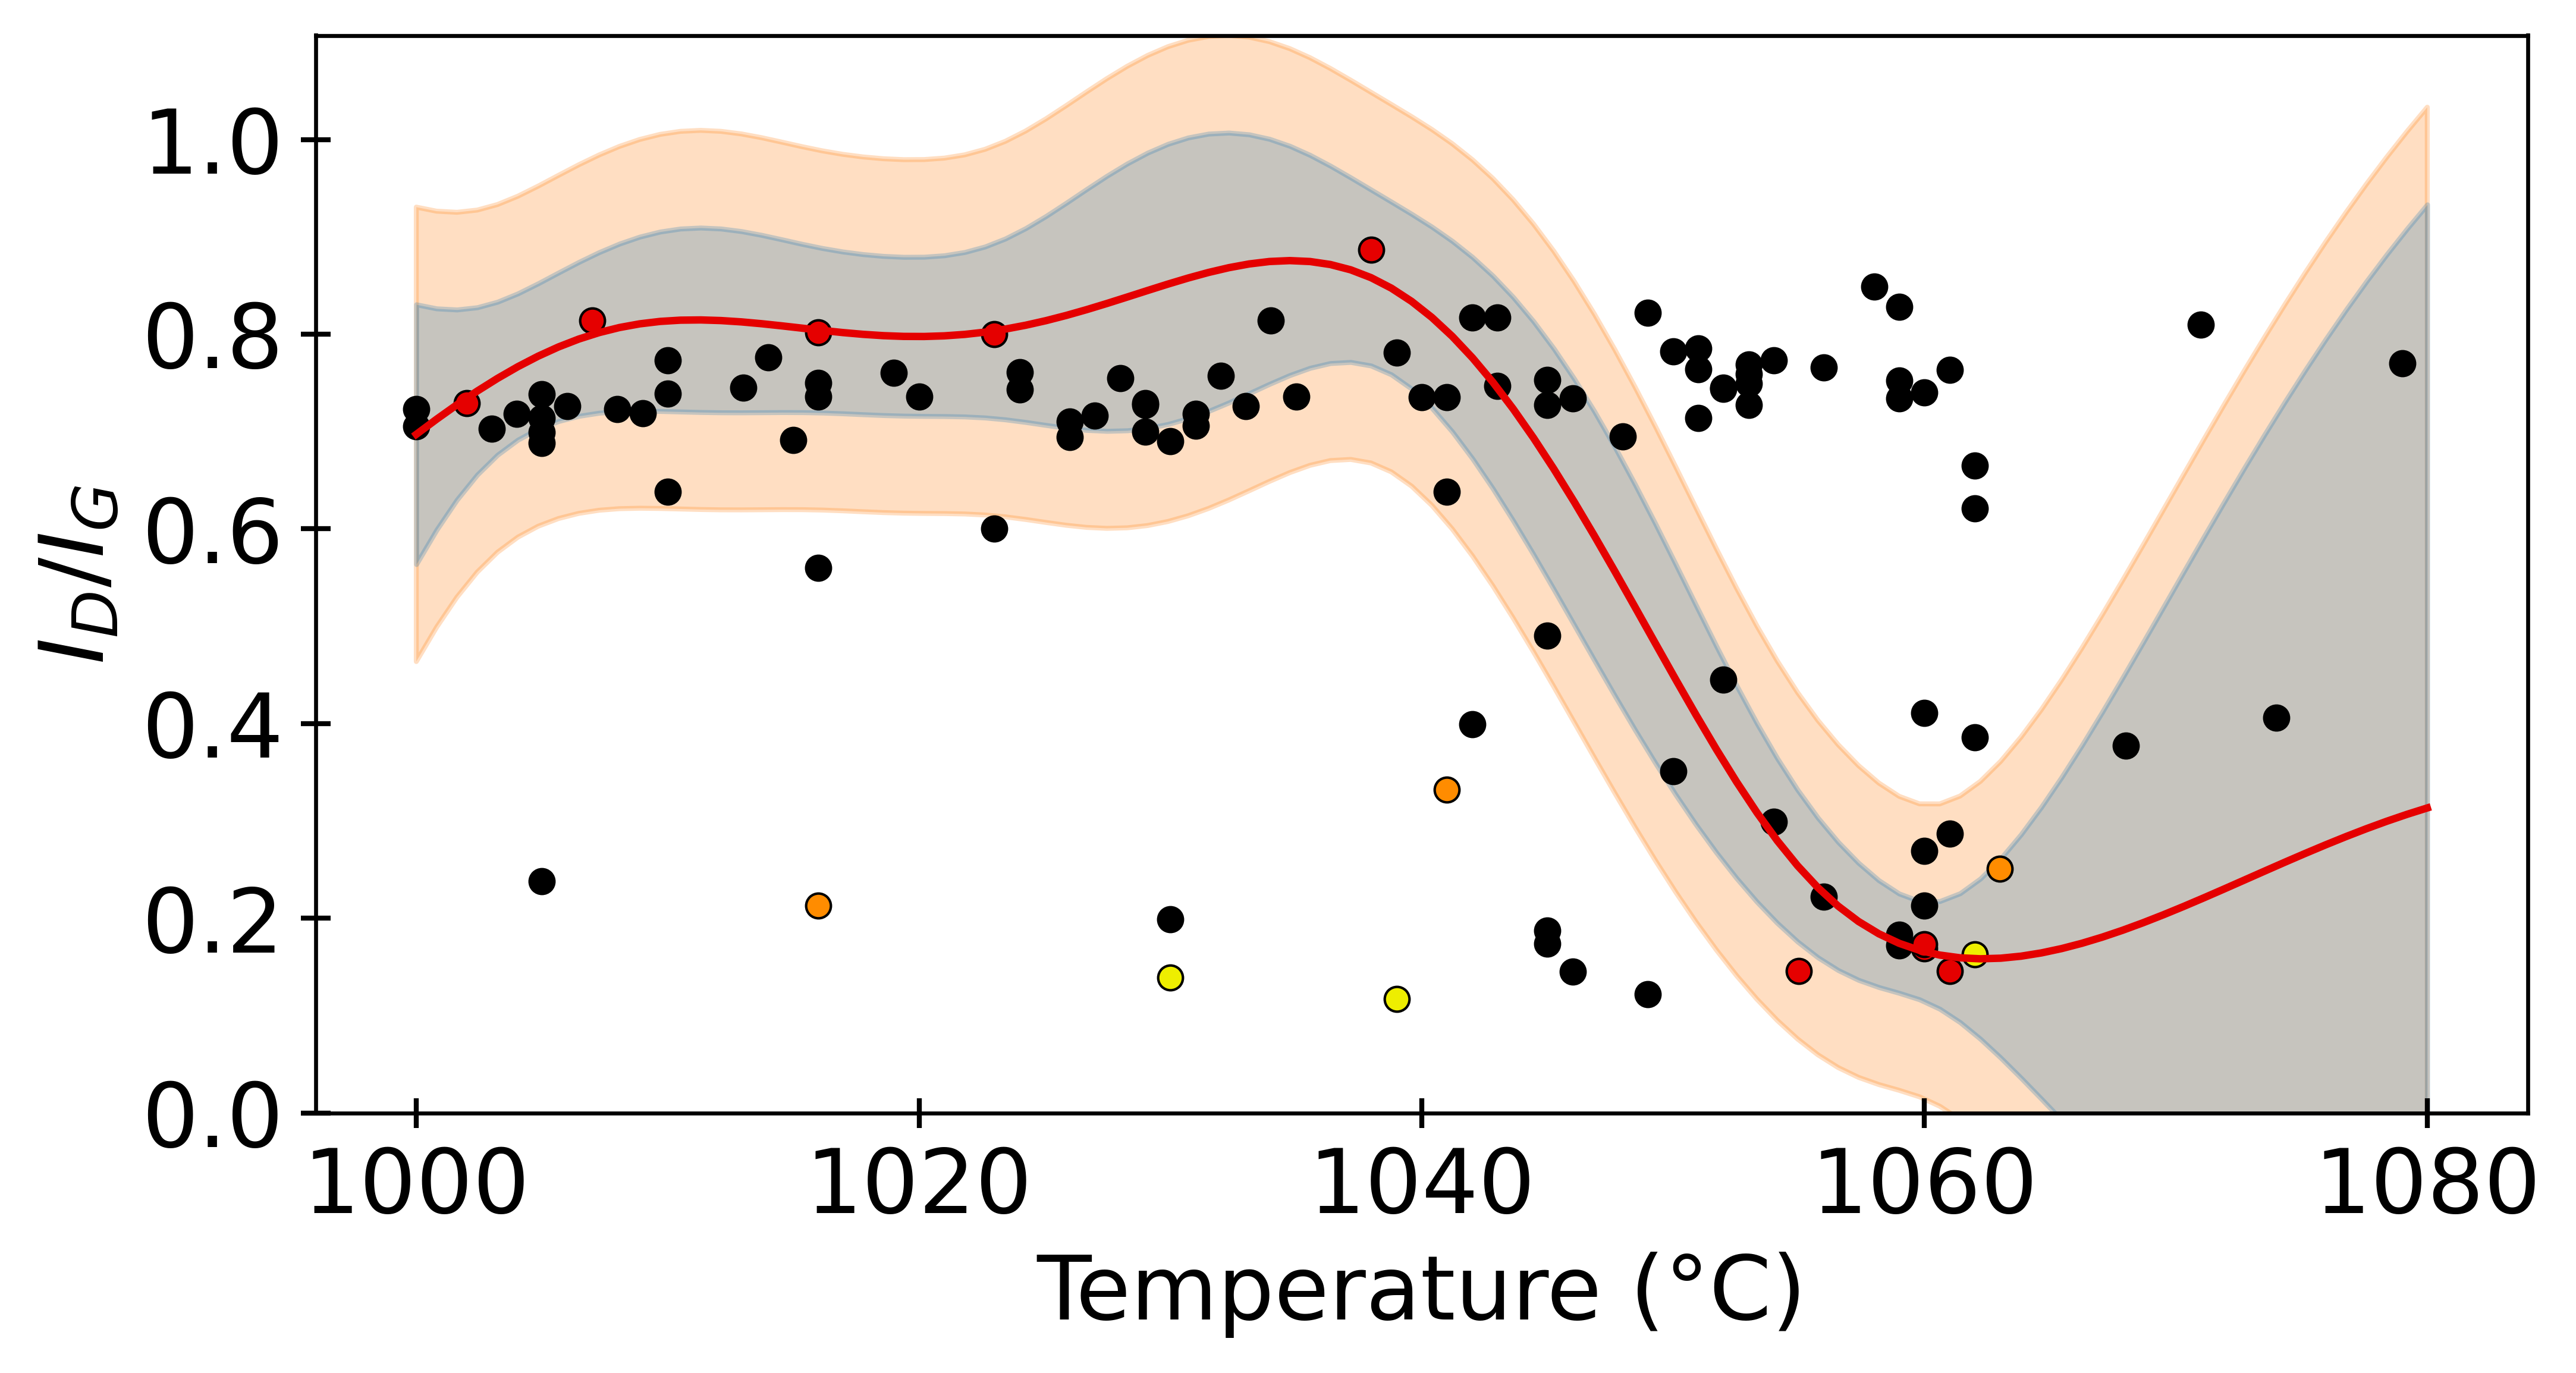

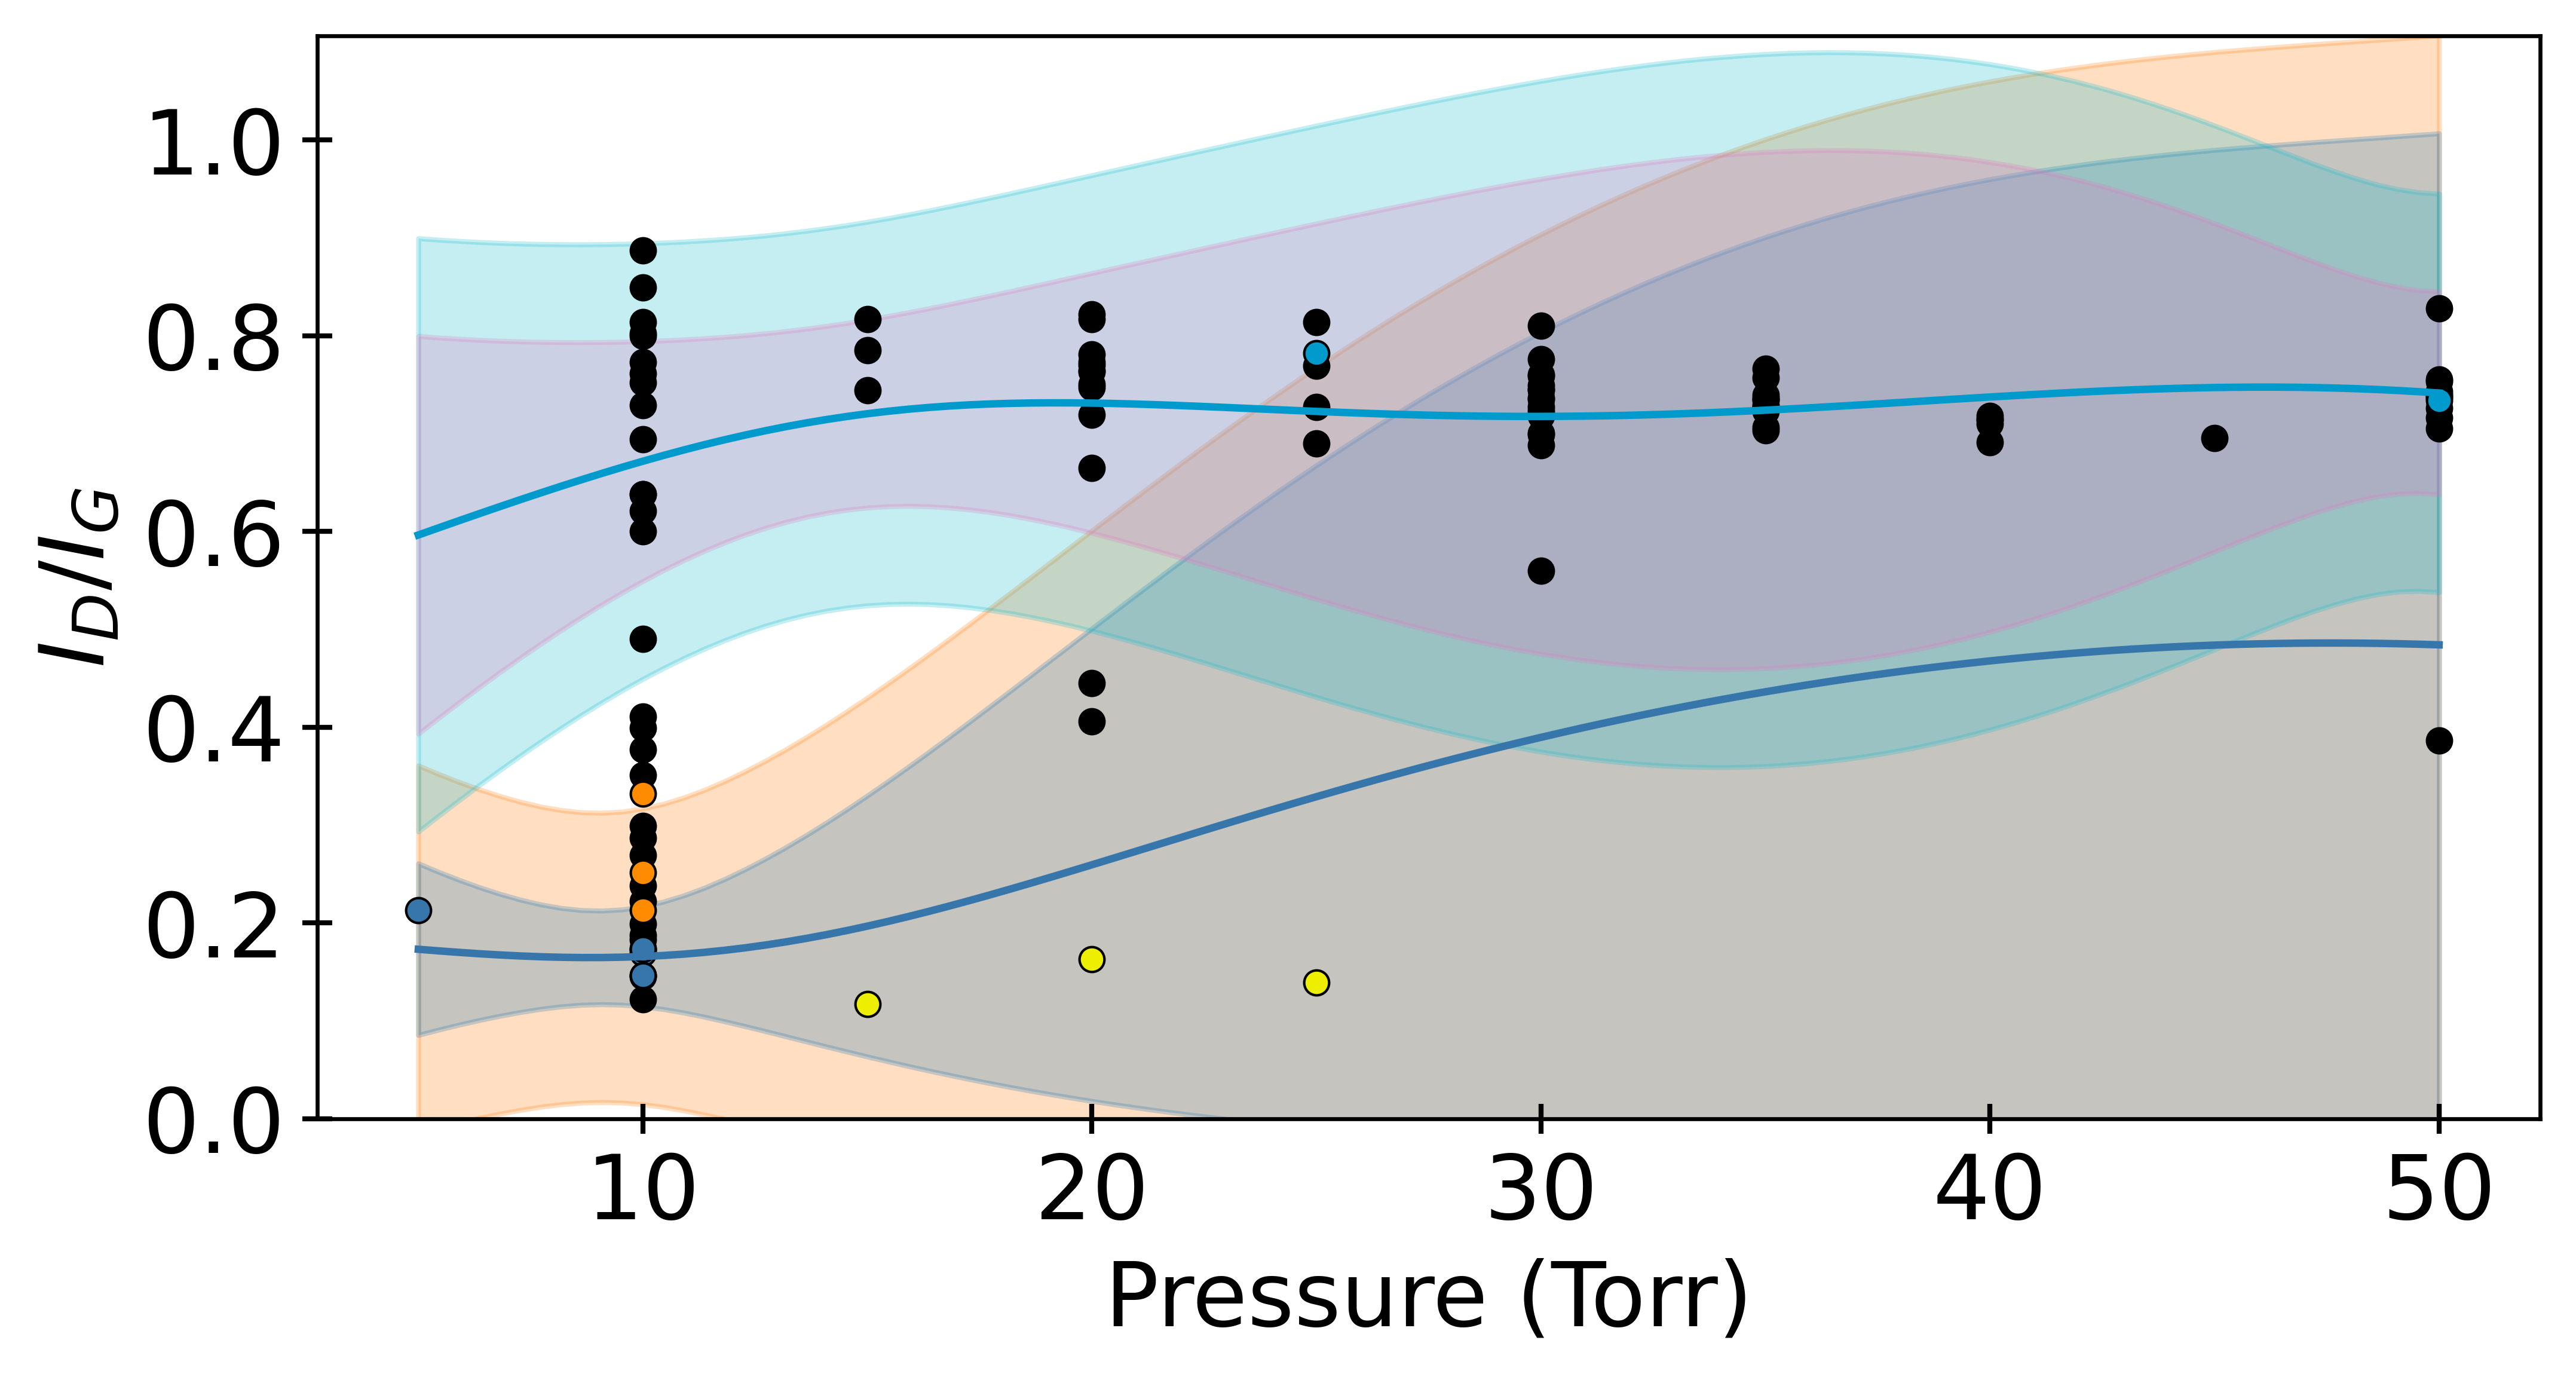

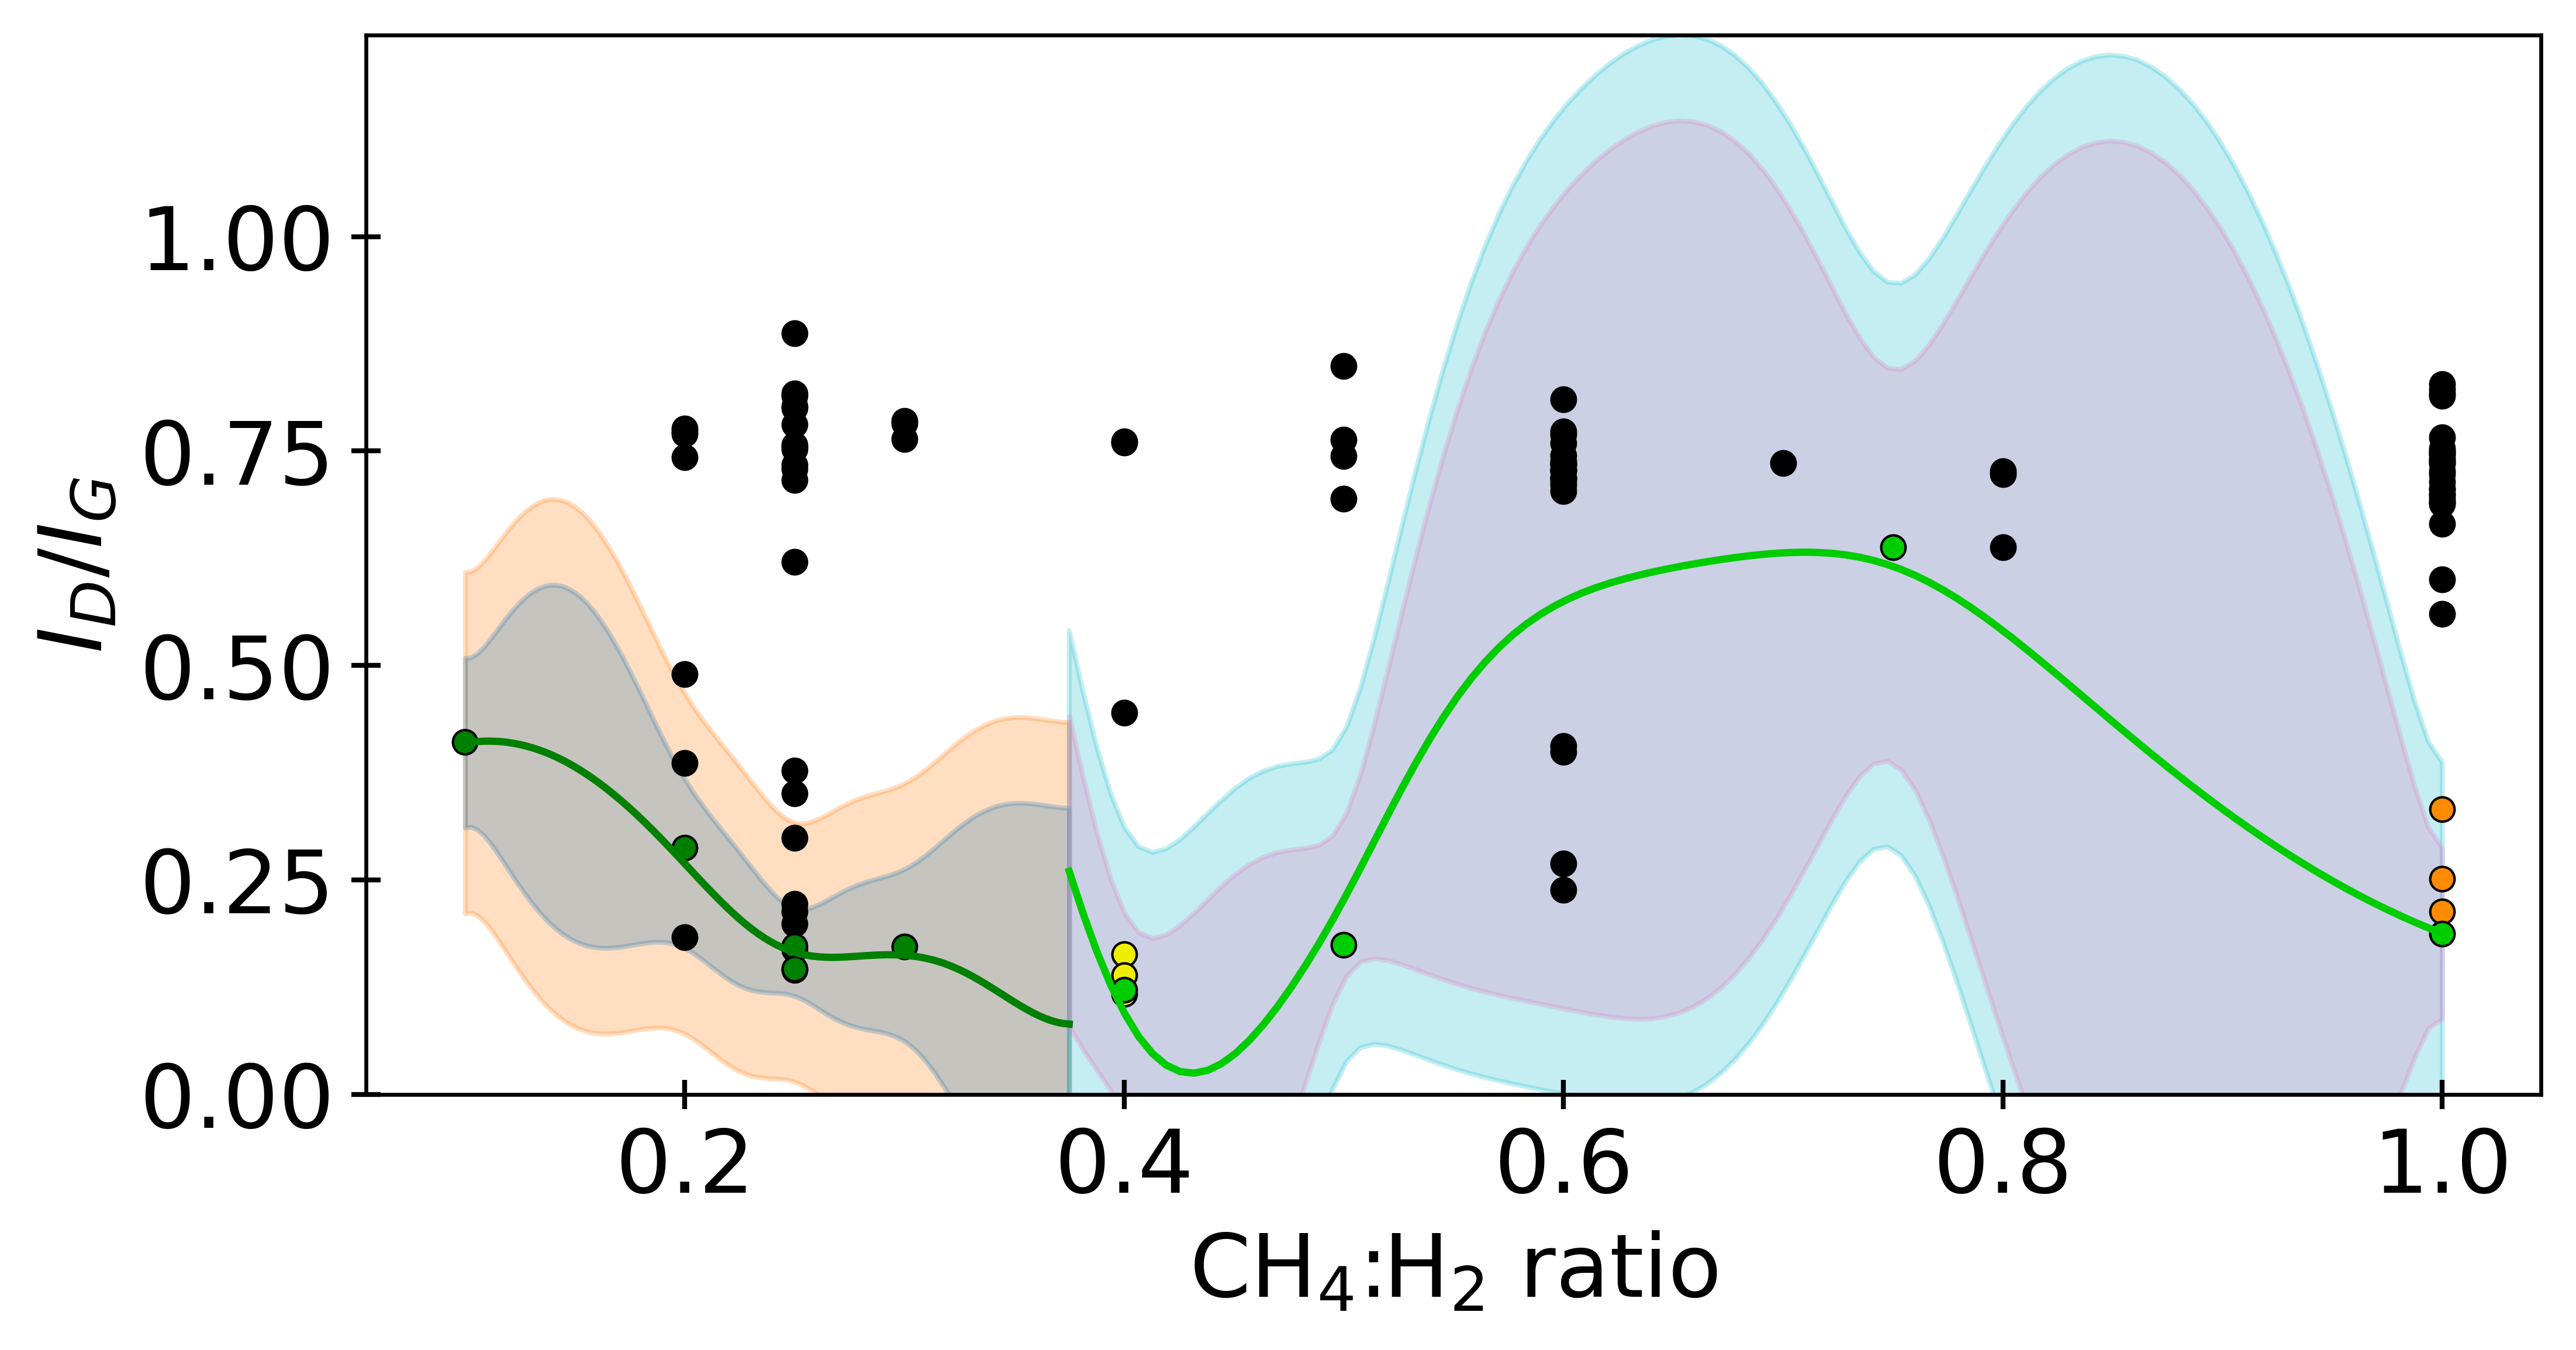

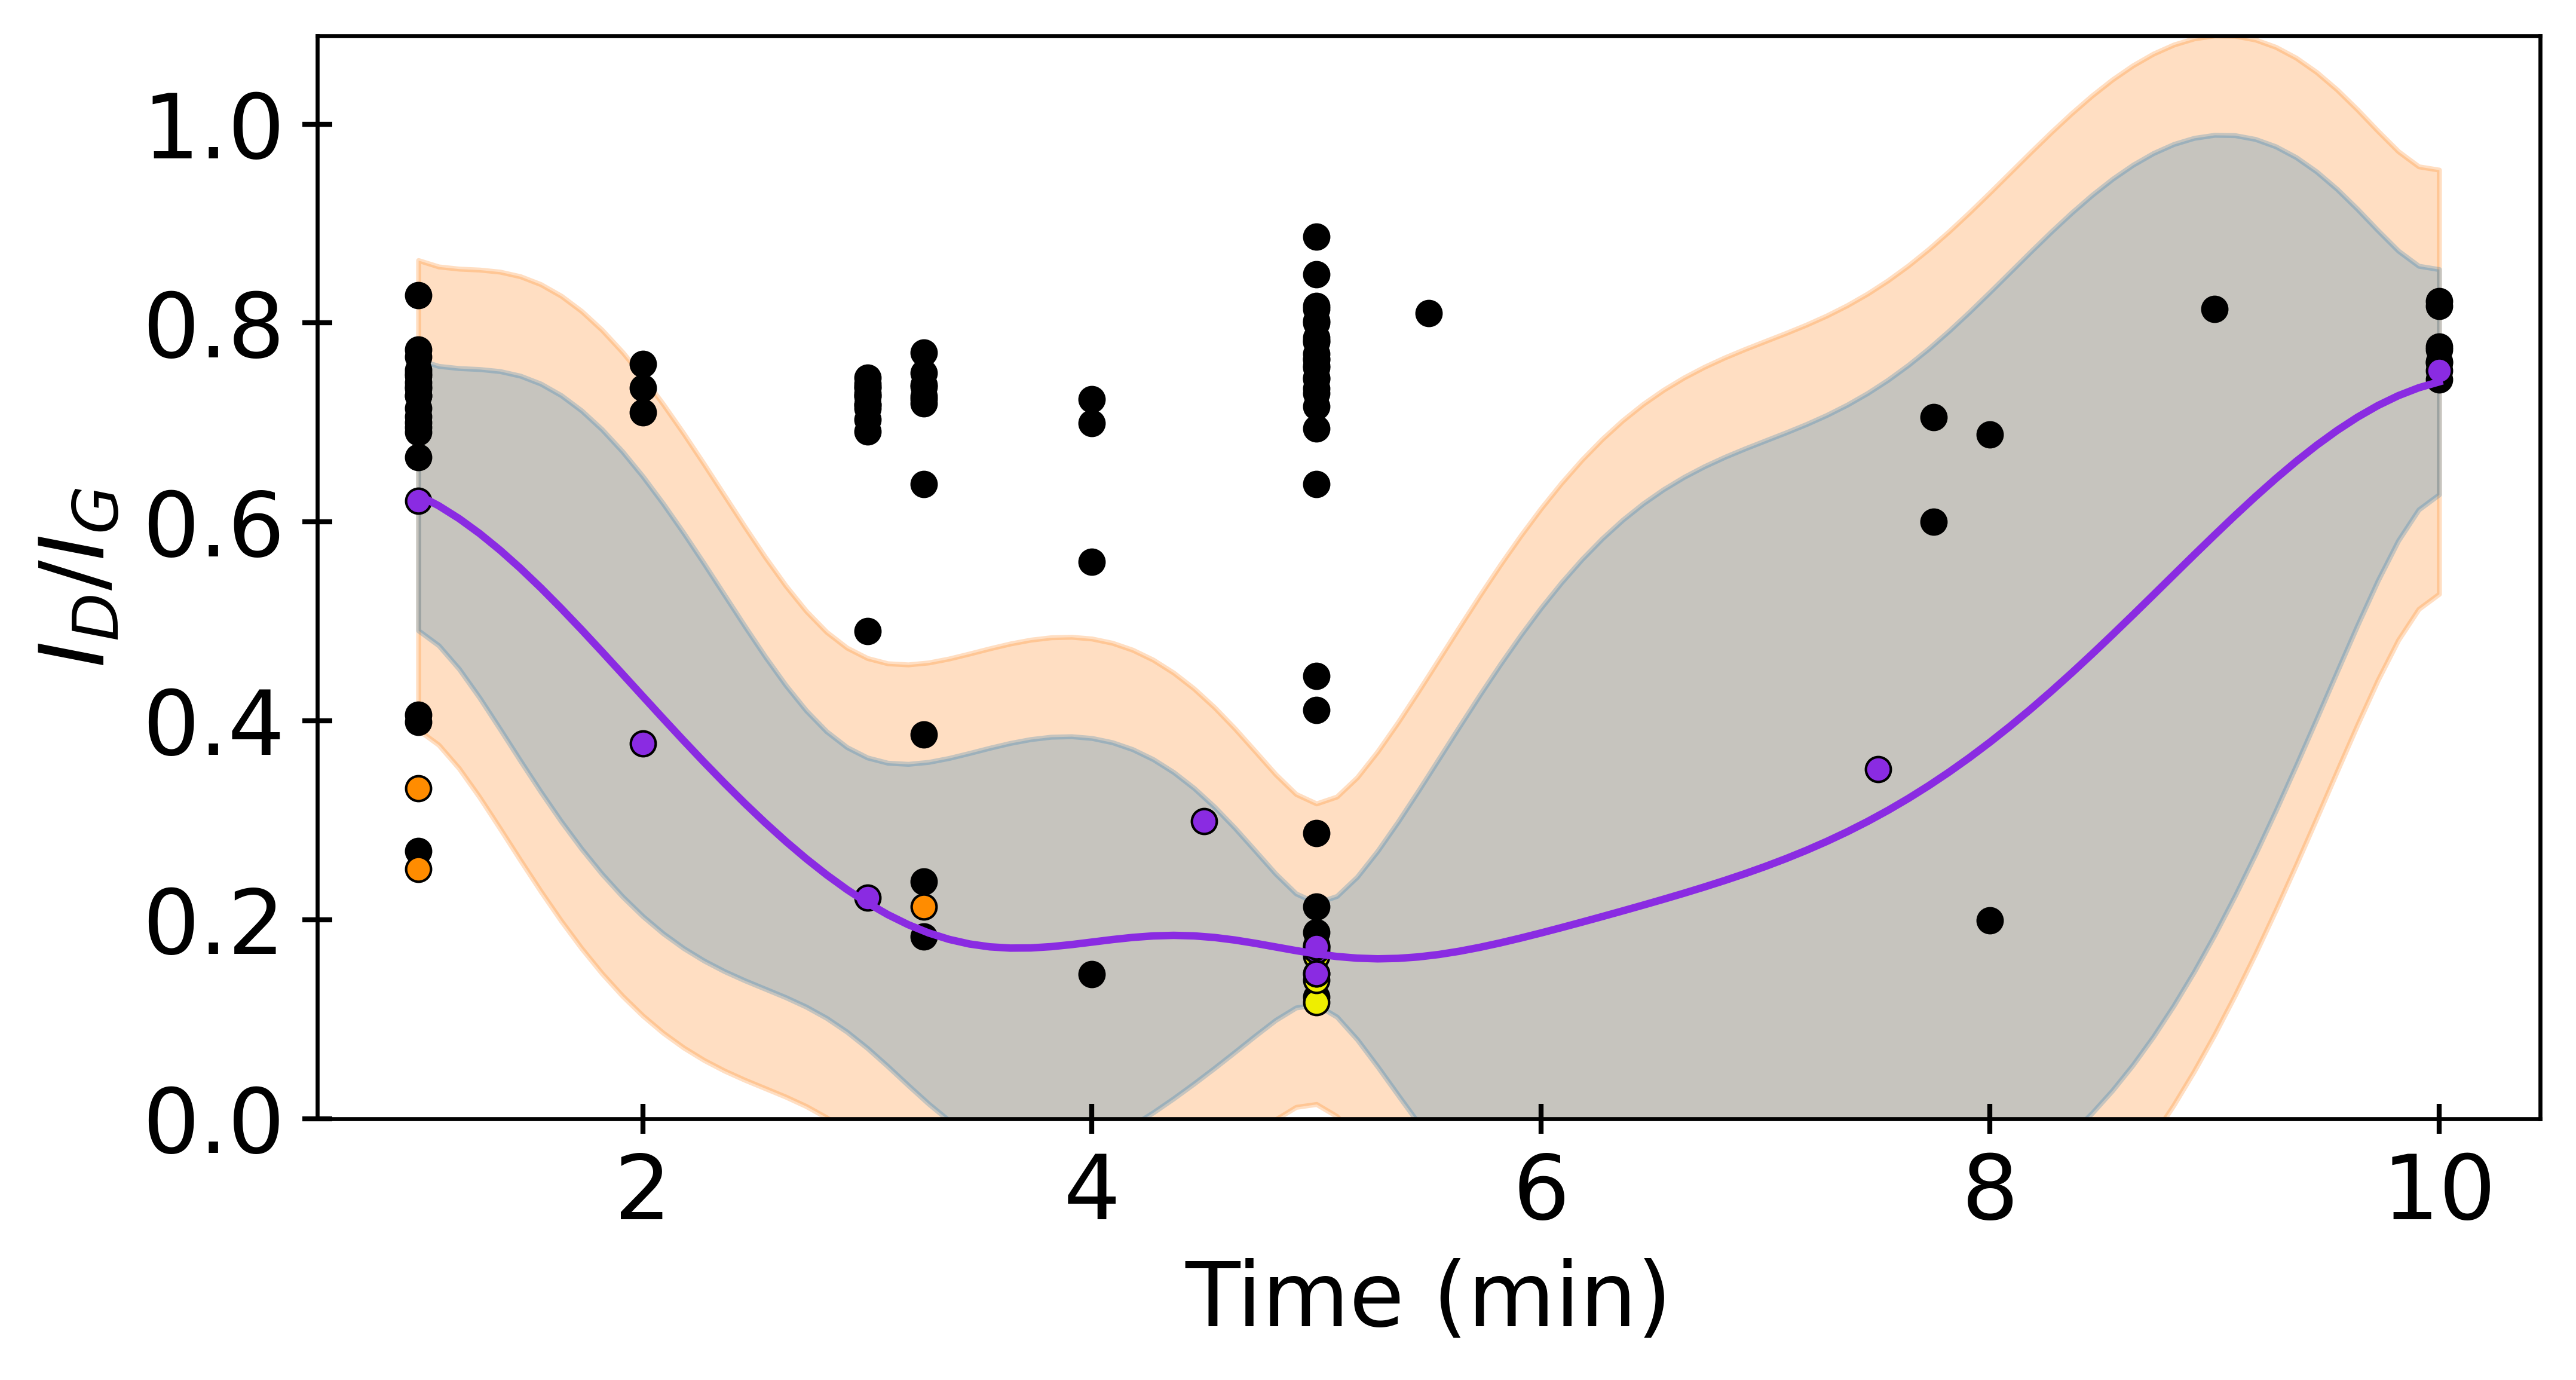

In [30]:
n=100
ϵ = 0
X_predict = np.zeros((n,d))
X_predict_ = np.zeros((n,d))
X_predict_T = np.zeros((n,d_T))


for i in range(d):
    if i == 0:
        X_predict[:,0] = np.linspace(1000,1080,n)
        X_predict[:,1] = np.ones(n) * 10
        X_predict[:,2] = np.ones(n) * 0.25
        X_predict[:,3] = np.ones(n) * 5
        X_predict_[:,0] = np.linspace(1000,1075,n)
        X_predict_[:,1] = np.ones(n) * 10
        X_predict_[:,2] = np.ones(n) * 0.25
        X_predict_[:,3] = np.ones(n) * 5
        x_label = 'Temperature (°C)'
        legend = '10 torr, CH$_{4}$:H$_{2}$ 1:4, 5 min'
        color = '#E50000'
        Y_ = data_red_temp[:,5]
        X_ = data_red_temp[:,0]
        Y_k = data_black_temp[:,5]
        X_k = data_black_temp[:,0]
        Y_g = data_gold[:,5]
        X_g = data_gold[:,0]
        Y_o = data_orange[:,5]
        X_o = data_orange[:,0]
    elif i == 1:
        X_predict[:,0] = np.ones(n) * 1060
        X_predict[:,1] = np.linspace(5,50,n)
        X_predict[:,2] = np.ones(n) * 0.25
        X_predict[:,3] = np.ones(n) * 5
        X_predict_[:,0] = np.ones(n) * 1045
        X_predict_[:,1] = np.linspace(5,50,n)
        X_predict_[:,2] = np.ones(n) * 0.25
        X_predict_[:,3] = np.ones(n) * 5
        x_label = 'Pressure (Torr)'
        legend = '1060 C, CH$_{4}$:H$_{2}$ 1:4, 5 min'
        color = '#3776ab'
        color_ = '#009ACD'
        Y_ = data_darkblue_pressure[:,5]
        X_ = data_darkblue_pressure[:,1]
        Y__ = data_lightblue_pressure[:,5]
        X__ = data_lightblue_pressure[:,1]
        Y_k = data_black_pressure[:,5]
        X_k = data_black_pressure[:,1]
        Y_g = data_gold[:,5]
        X_g = data_gold[:,1]
        Y_o = data_orange[:,5]
        X_o = data_orange[:,1]
    elif i ==2:
        X_predict[:,0] = np.ones(n) * 1060
        X_predict[:,1] = np.ones(n) * 10
        X_predict[:,2] = np.linspace(0.1,0.375,n)
        X_predict[:,3] = np.ones(n) * 5
        X_predict_[:,0] = np.ones(n) * 1045
        X_predict_[:,1] = np.ones(n) * 10
        X_predict_[:,2] = np.linspace(0.375,1,n)
        X_predict_[:,3] = np.ones(n) * 5
        x_label = 'CH$_{4}$:H$_{2}$ ratio'
        legend = '1060 C, 10 torr, 5 min'
        color = '#008000'
        color_ = '#00CD00'
        Y_ = data_darkgreen_ratio[:,5]
        X_ = data_darkgreen_ratio[:,2]
        Y__ = data_lightgreen_ratio[:,5]
        X__ = data_lightgreen_ratio[:,2]
        Y_k = data_black_ratio[:,5]
        X_k = data_black_ratio[:,2]
        Y_g = data_gold[:,5]
        X_g = data_gold[:,2]
        Y_o = data_orange[:,5]
        X_o = data_orange[:,2]
    else: 
        X_predict[:,0] = np.ones(n) * 1060
        X_predict[:,1] = np.ones(n) * 10
        X_predict[:,2] = np.ones(n) * 0.25
        X_predict[:,3] = np.linspace(1,10,n)
        X_predict_[:,0] = np.ones(n) * 1060
        X_predict_[:,1] = np.ones(n) * 10
        X_predict_[:,2] = np.ones(n) * 0.25
        X_predict_[:,3] = np.linspace(1,10,n)
        x_label = 'Time (min)'
        legend = '1060 C, 10 torr, CH$_{4}$:H$_{2}$ 1:4'
        color = '#8A2BE2'
        Y_ = data_purple_time[:,5]
        X_ = data_purple_time[:,3]
        Y_k = data_black_time[:,5]
        X_k = data_black_time[:,3]
        Y_g = data_gold[:,5]
        X_g = data_gold[:,3]
        Y_o = data_orange[:,5]
        X_o = data_orange[:,3]
  
    # likelihood
    
    mn, v = gp.predict(X_predict)
    mn_, v_ = gp.predict(X_predict_)
    σ = np.sqrt(v - σ_n ** 2)
    σ_ = np.sqrt(v_ - σ_n_ ** 2)
    # And you can visualize the results as follows
    # Standard deviation
    # Lower quantile
    l = mn - 2 * σ
    u = mn + 2 * σ
    l_ = mn_ - 2 * σ_
    u_ = mn_ + 2 * σ_
    # Sample
    gp_post_samples = gp.posterior_samples_f(X_predict, 20)[:, 0]
    gp_post_samples_ = gp.posterior_samples_f(X_predict_, 20)[:, 0]
#     fig, ax = plt.subplots(dpi=100)
#     ax.plot(X_predict[:,i], gp_post_samples, 'r', lw=0.5)
#     ax.plot(X[:,i], Y, 'kx', markersize=10, markeredgewidth=2)
#     ax.set_ylim(0, np.max(gp_post_samples))
#     ax.set_xlabel(x_label)
#     ax.set_ylabel('$I_{D}$/$I_{G}$')
    
    fig, ax = plt.subplots(figsize=(8,4), dpi=600)
    plt.rc('font', size=14) 
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    ax.plot(X_k, Y_k, color='#000000', marker='.', linestyle='None', markeredgecolor ='#000000', markersize=10, markeredgewidth=0.5, label=legend)
    ax.plot(X_g, Y_g, color='#EEEE00', marker='.', linestyle='None', markeredgecolor ='#000000', markersize=10, markeredgewidth=0.5, label=legend)
    ax.plot(X_o, Y_o, color='#FF8C00', marker='.', linestyle='None', markeredgecolor ='#000000', markersize=10, markeredgewidth=0.5, label=legend)
    ax.plot(X_, Y_, color=color, marker='.', linestyle='None', markeredgecolor ='#000000', markersize=10, markeredgewidth=0.5, label=legend)
    #     ax.plot(X[:,i], Y, color='#000000', marker='.', linestyle='None', markersize=10, markeredgewidth=2, label=legend)
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel('$I_{D}$/$I_{G}$', fontsize=18)
    ax.tick_params(direction='inout', length=6, width=1, colors='k',
               grid_color='r', grid_alpha=0.5, labelsize =18)
    ax.plot(X_predict[:,i], mn, color = color)
    ax.fill_between(X_predict[:,i], l.flatten() - 2.0 * σ_n, u.flatten() + 2.0 * σ_n, color=sns.color_palette()[1], alpha=0.25);
    ax.fill_between(X_predict[:,i], l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25);
    if i == 1 or i == 2:
        ax.plot(X__, Y__, color=color_, marker='.', linestyle='None', markeredgecolor ='#000000', markersize=10, markeredgewidth=0.5, label=legend)
        ax.plot(X_predict_[:,i], mn_, color = color_)
        ax.fill_between(X_predict_[:,i], l_.flatten() - 2.0 * σ_n_, u_.flatten() + 2.0 * σ_n_, color=sns.color_palette()[9], alpha=0.25);
        ax.fill_between(X_predict_[:,i], l_.flatten(), u_.flatten(), color=sns.color_palette()[6], alpha=0.25);
        
        

        
    ylim = max(np.max(u.flatten() + 2.0 * σ_n),np.max(u_.flatten() + 2.0 * σ_n_))
    ax.set_ylim(0, ylim)
#     plt.legend()
#     plt.savefig("Regression"x_label".png", transparent=True, dpi=600)
# # 1D acuisition function
#     af_all = minimize_w_noise_1d(gp, X_predict, i, ϵ, alpha=ei, psi=0., max_it=2)
    
    
# for i in range(d_T):
#     if i == 0:
#         X_predict_T[:,0] = np.linspace(10,50,n)
#         X_predict_T[:,1] = np.ones(n) * 0.25
#         X_predict_T[:,2] = np.ones(n) * 106
#         x_label = 'pressure (Torr)'
#     elif i == 1:
#         X_predict_T[:,0] = np.ones(n) * 10
#         X_predict_T[:,1] = np.linspace(0.2,1,n)
#         X_predict_T[:,2] = np.ones(n) * 106  
#         x_label = '$CH_{4}/H_{2}$ (Torr)'
#     else:
#         X_predict_T[:,0] = np.ones(n) * 10
#         X_predict_T[:,1] = np.ones(n) * 0.25
#         X_predict_T[:,2] = np.linspace(100,106,n)
#         x_label = 'Solar simulator power supply current (A)'
        
#     mn_T, v_T = gp_T.predict(X_predict_T)
#     σ_T = np.sqrt(v_T - σ_n_T ** 2)
#     # And you can visualize the results as follows
#     # Standard deviation
#     # Lower quantile
#     l_T = mn_T - 2 * σ_T
#     u_T = mn_T + 2 * σ_T
#     # Sample
#     gp_T_post_samples = gp_T.posterior_samples_f(X_predict_T, 20)[:, 0]
#     fig, ax = plt.subplots(dpi=100)
#     ax.plot(X_predict_T[:,i], gp_T_post_samples, 'r', lw=0.5)
#     ax.plot(X_T[:,i], Y_T, 'kx', markersize=10, markeredgewidth=2)
#     fig, ax = plt.subplots(dpi=100)
#     ax.plot(X_T[:,i], Y_T, 'kx', markersize=10, markeredgewidth=2)
#     if i == 2:
#         ax.set_xlim(np.min(X_predict_T[:,2]), np.max(X_predict_T[:,2]))
#     ax.set_xlabel(x_label)
#     ax.set_ylabel('Temperature (C)')
#     ax.plot(X_predict_T[:,i], mn_T)
#     ax.fill_between(X_predict_T[:,i], l_T.flatten() - 2.0 * σ_n_T, u_T.flatten() + 2.0 * σ_n_T, color=sns.color_palette()[1], alpha=0.25);
#     ax.fill_between(X_predict_T[:,i], l_T.flatten(), u_T.flatten(), color=sns.color_palette()[0], alpha=0.25);
    
    

[[1.00000000e+03 5.00000000e+00 1.00000000e-01 1.00000000e+00]
 [1.00888889e+03 1.00000000e+01 2.00000000e-01 2.00000000e+00]
 [1.01777778e+03 1.50000000e+01 3.00000000e-01 3.00000000e+00]
 [1.02666667e+03 2.00000000e+01 4.00000000e-01 4.00000000e+00]
 [1.03555556e+03 2.50000000e+01 5.00000000e-01 5.00000000e+00]
 [1.04444444e+03 3.00000000e+01 6.00000000e-01 6.00000000e+00]
 [1.05333333e+03 3.50000000e+01 7.00000000e-01 7.00000000e+00]
 [1.06222222e+03 4.00000000e+01 8.00000000e-01 8.00000000e+00]
 [1.07111111e+03 4.50000000e+01 9.00000000e-01 9.00000000e+00]
 [1.08000000e+03 5.00000000e+01 1.00000000e+00 1.00000000e+01]]
p=0
1062.2222222222222
[[1.00000000e+03 1.00000000e+01 5.00000000e-01 5.00000000e+00]
 [1.00888889e+03 1.00000000e+01 5.00000000e-01 5.00000000e+00]
 [1.01777778e+03 1.00000000e+01 5.00000000e-01 5.00000000e+00]
 [1.02666667e+03 1.00000000e+01 5.00000000e-01 5.00000000e+00]
 [1.03555556e+03 1.00000000e+01 5.00000000e-01 5.00000000e+00]
 [1.04444444e+03 1.00000000e+01

 <ipython-input-25-7e587e58d00d>:17: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1017.7777777777778
[[1.00000000e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.00888889e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.01777778e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.02666667e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.03555556e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.04444444e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.05333333e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.06222222e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.07111111e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.08000000e+03 2.00000000e+01 6.00000000e-01 4.00000000e+00]]
0.7297742740671791
1062.2222222222222
[[1.00000000e+03 2.00000000e+01 6.00000000e-01 5.00000000e+00]
 [1.00888889e+03 2.00000000e+01 6.00000000e-01 5.00000000e+00]
 [1.01777778e+03 2.00000000e+01 6.00000000e-01 5.00000000e+00]
 [1.02666667e+03 2.00000000e+01 6.00000000e-01 5.00000000e+00]
 [1.03555556e+03 2.00000000e+01 6.00000000e-01 5.00000000e+0

1017.7777777777778
[[1.00000000e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.00888889e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.02666667e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.03555556e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.04444444e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.05333333e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.06222222e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.07111111e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.08000000e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]]
0.7002568967215468
1008.8888888888889
[[1.00000000e+03 4.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.00888889e+03 4.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.01777778e+03 4.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.02666667e+03 4.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.03555556e+03 4.00000000e+01 6.00000000e-01 4.00000000e+0

20.0
[[1.06222222e+03 5.00000000e+00 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 1.00000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 1.50000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 2.00000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 2.50000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 3.00000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 3.50000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 4.00000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 4.50000000e+01 6.00000000e-01 6.00000000e+00]
 [1.06222222e+03 5.00000000e+01 6.00000000e-01 6.00000000e+00]]
0.7002104675227736
20.0
[[1.07111111e+03 5.00000000e+00 6.00000000e-01 5.00000000e+00]
 [1.07111111e+03 1.00000000e+01 6.00000000e-01 5.00000000e+00]
 [1.07111111e+03 1.50000000e+01 6.00000000e-01 5.00000000e+00]
 [1.07111111e+03 2.00000000e+01 6.00000000e-01 5.00000000e+00]
 [1.07111111e+03 2.50000000e+01 6.00000000e-01 5.00000000e+00]
 [1.07111111e+03 3.000000

0.6
[[1.01777778e+03 3.50000000e+01 1.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 2.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 3.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 4.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 5.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 6.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 8.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 9.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 1.00000000e+00 3.00000000e+00]]
0.7013740548525106
0.6
[[1.01777778e+03 3.50000000e+01 1.00000000e-01 4.00000000e+00]
 [1.01777778e+03 3.50000000e+01 2.00000000e-01 4.00000000e+00]
 [1.01777778e+03 3.50000000e+01 3.00000000e-01 4.00000000e+00]
 [1.01777778e+03 3.50000000e+01 4.00000000e-01 4.00000000e+00]
 [1.01777778e+03 3.50000000e+01 5.00000000e-01 4.00000000e+00]
 [1.01777778e+03 3.50000000

0.6
[[1.06222222e+03 2.50000000e+01 1.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 2.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 3.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 4.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 5.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 6.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 7.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 8.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 9.00000000e-01 5.00000000e+00]
 [1.06222222e+03 2.50000000e+01 1.00000000e+00 5.00000000e+00]]
0.7387858172227153
0.6
[[1.06222222e+03 3.00000000e+01 1.00000000e-01 5.00000000e+00]
 [1.06222222e+03 3.00000000e+01 2.00000000e-01 5.00000000e+00]
 [1.06222222e+03 3.00000000e+01 3.00000000e-01 5.00000000e+00]
 [1.06222222e+03 3.00000000e+01 4.00000000e-01 5.00000000e+00]
 [1.06222222e+03 3.00000000e+01 5.00000000e-01 5.00000000e+00]
 [1.06222222e+03 3.00000000

4.0
[[1.01777778e+03 3.50000000e+01 7.00000000e-01 1.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 2.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 3.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 4.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 5.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 6.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 7.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 8.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 9.00000000e+00]
 [1.01777778e+03 3.50000000e+01 7.00000000e-01 1.00000000e+01]]
0.7002568967215431
4.0
[[1.01777778e+03 4.00000000e+01 6.00000000e-01 1.00000000e+00]
 [1.01777778e+03 4.00000000e+01 6.00000000e-01 2.00000000e+00]
 [1.01777778e+03 4.00000000e+01 6.00000000e-01 3.00000000e+00]
 [1.01777778e+03 4.00000000e+01 6.00000000e-01 4.00000000e+00]
 [1.01777778e+03 4.00000000e+01 6.00000000e-01 5.00000000e+00]
 [1.01777778e+03 4.00000000

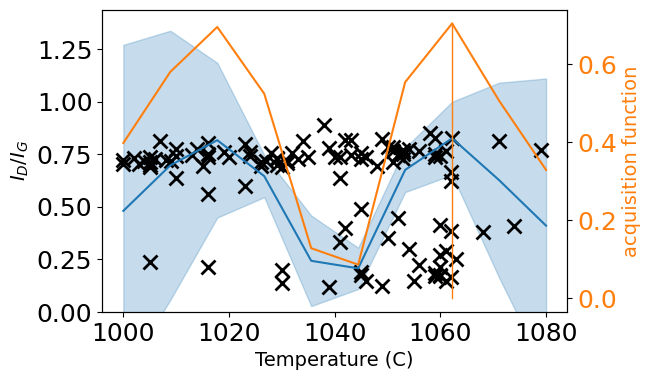

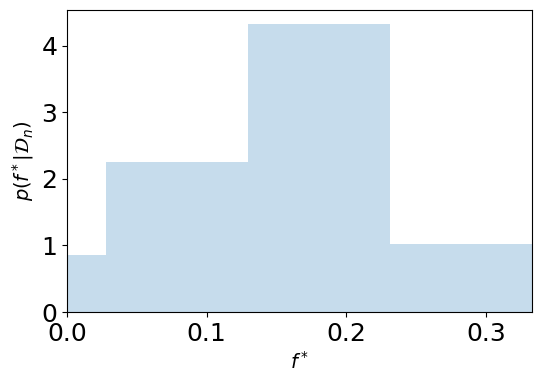

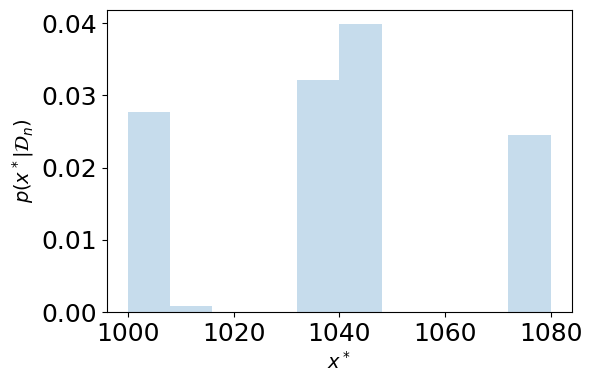

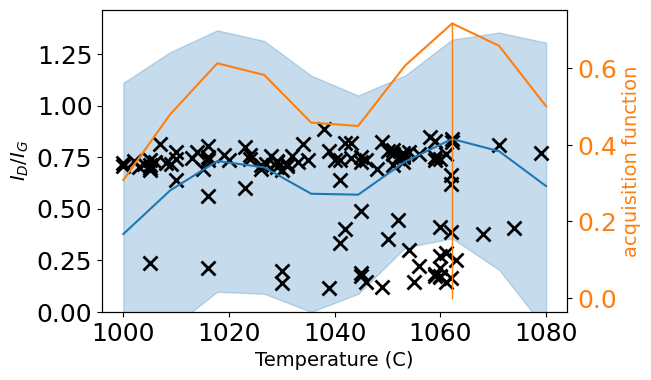

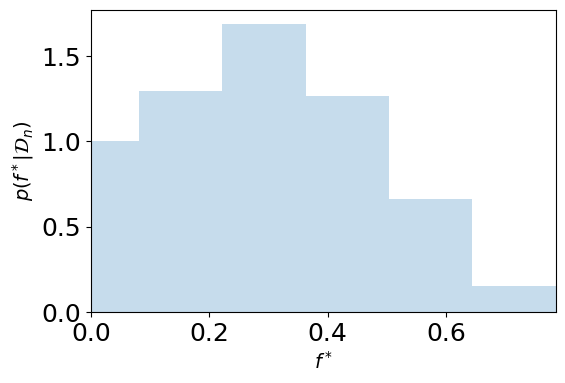

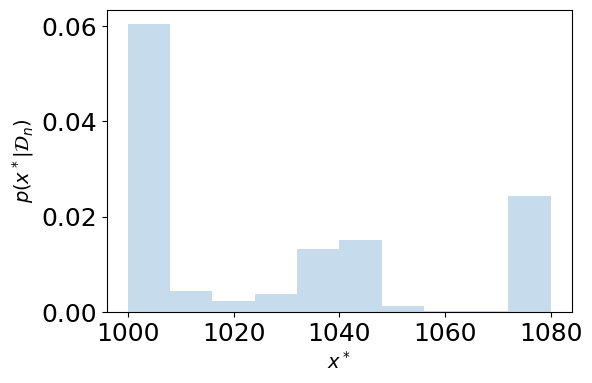

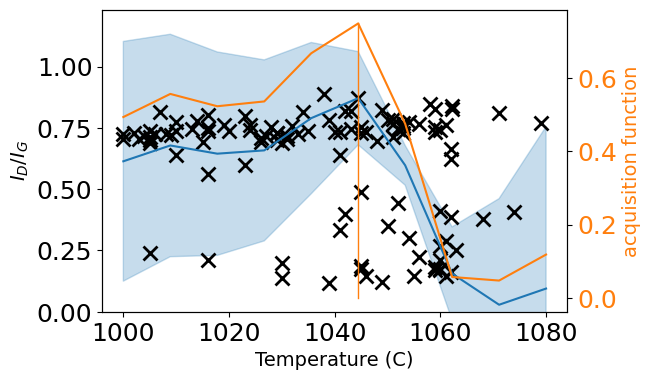

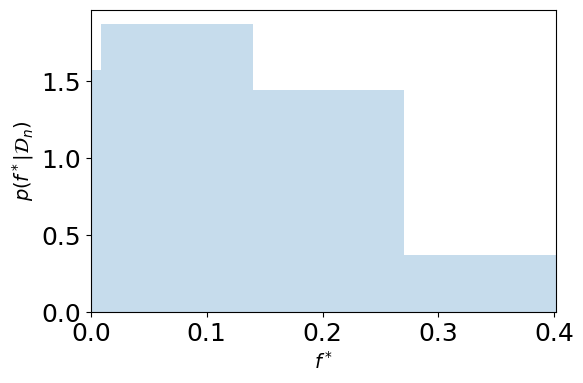

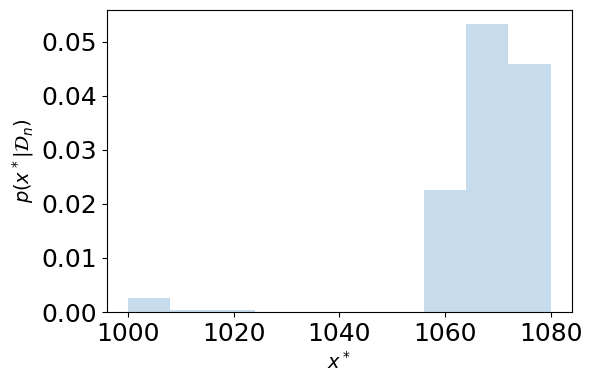

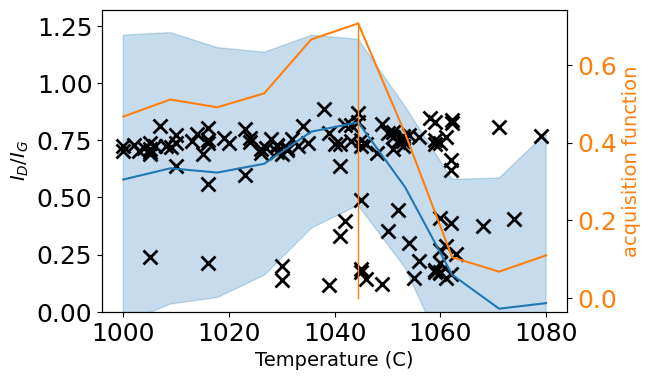

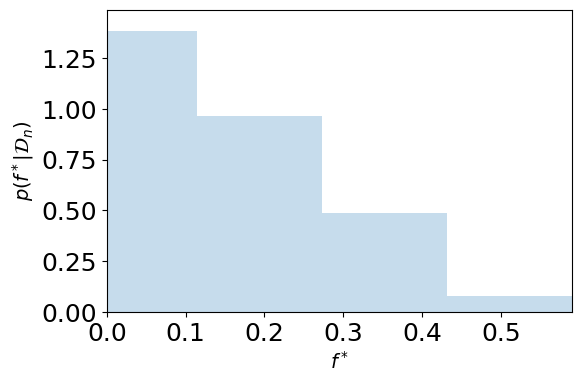

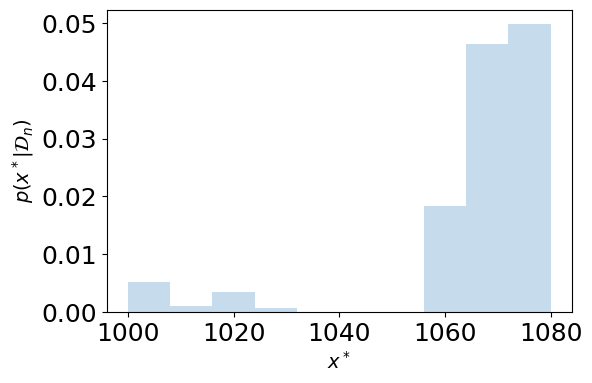

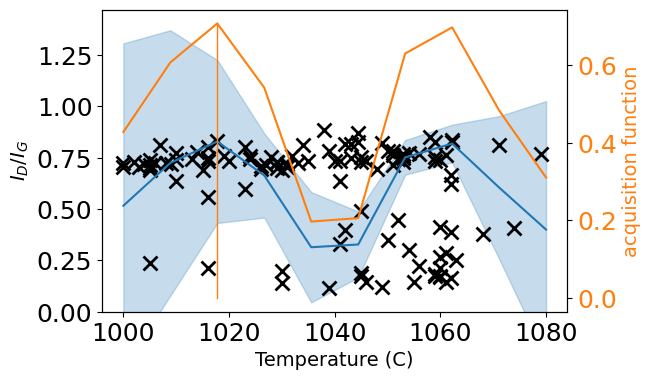

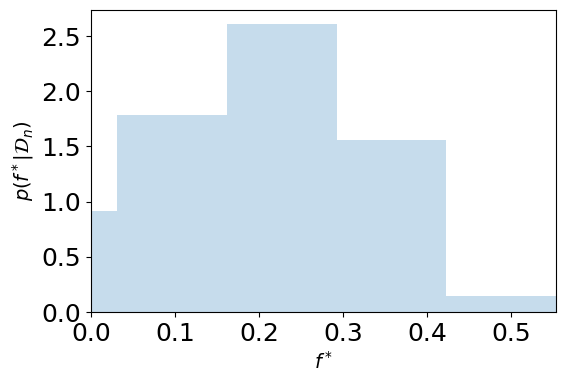

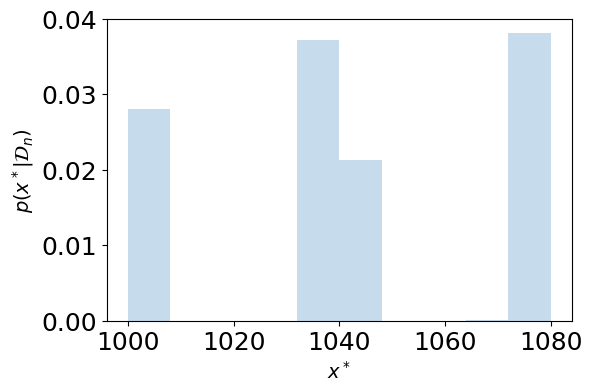

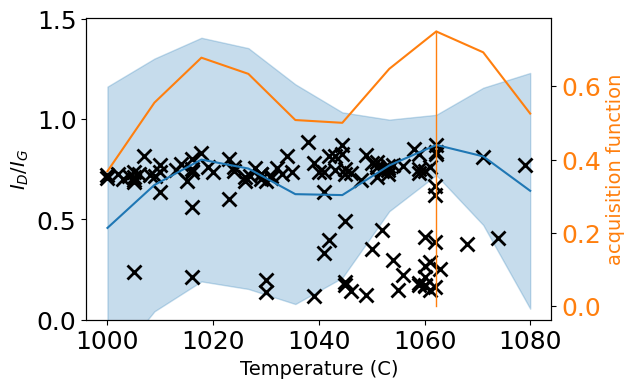

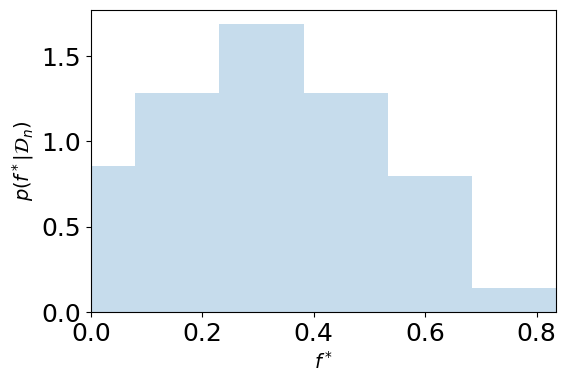

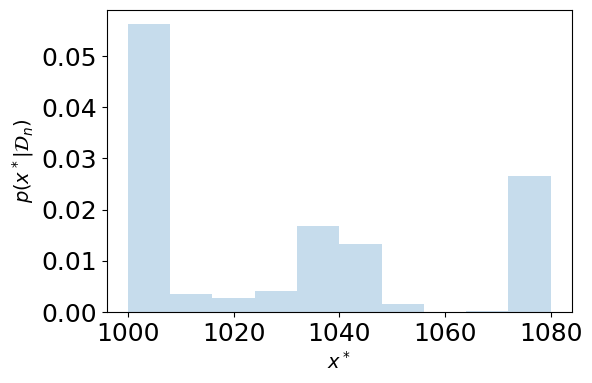

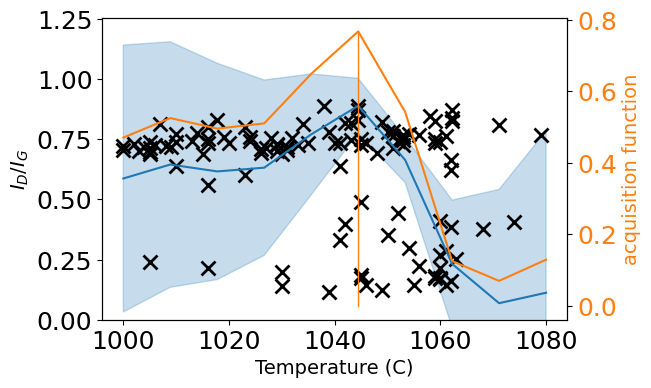

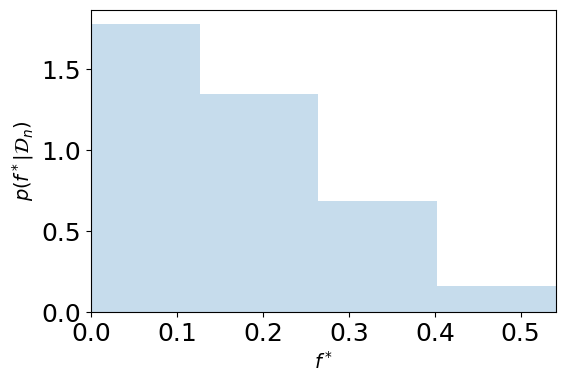

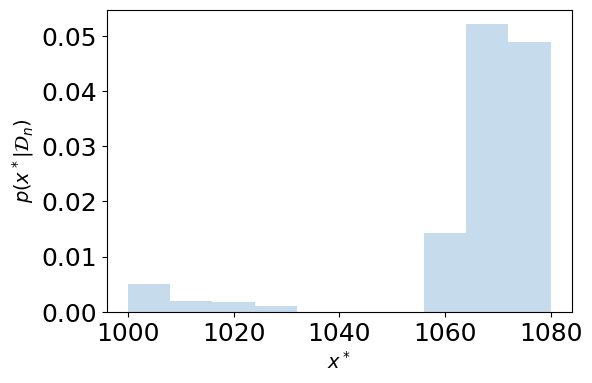

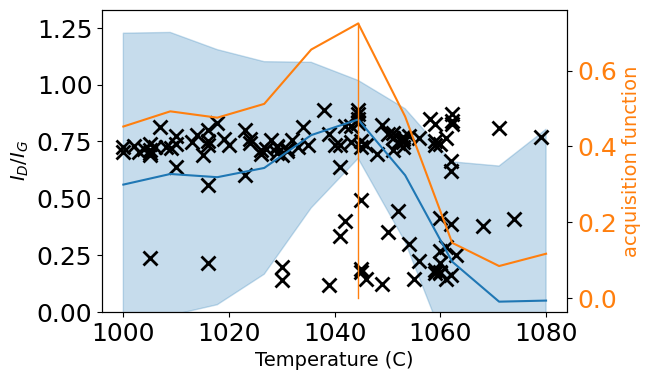

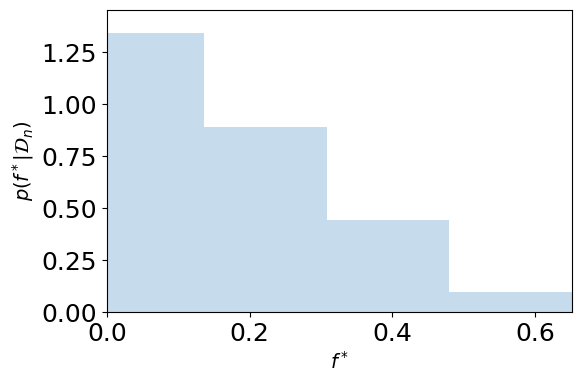

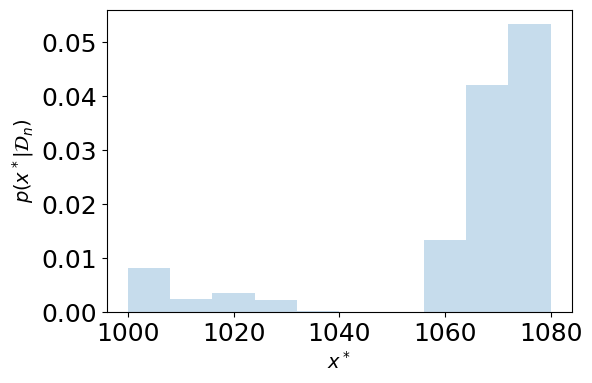

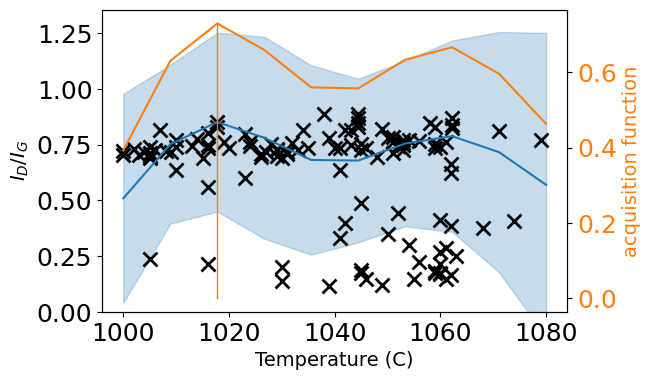

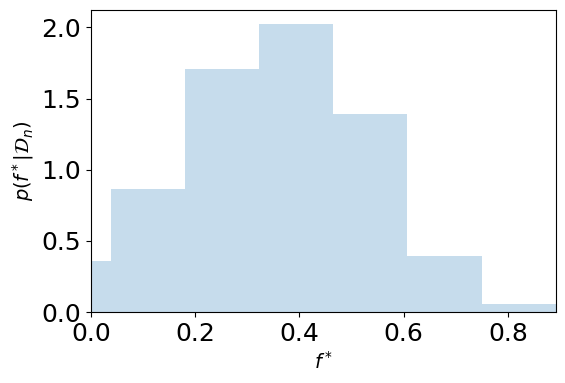

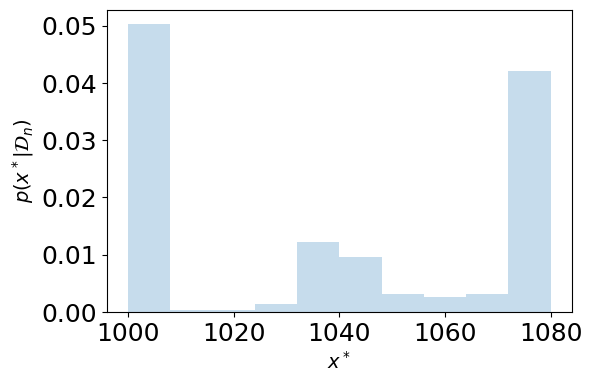

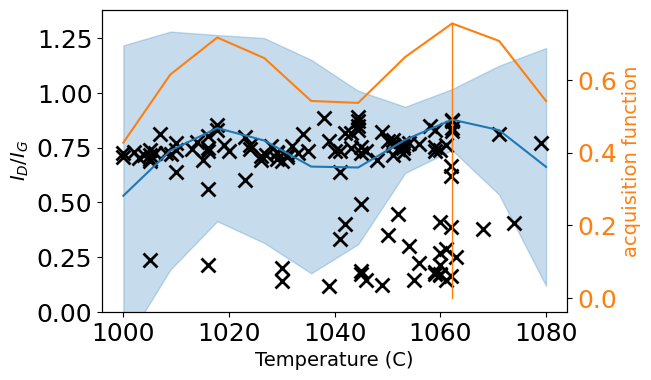

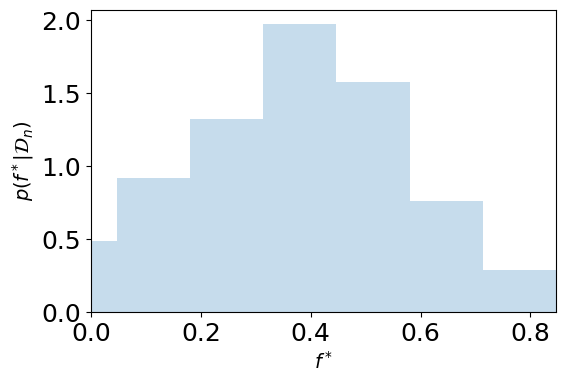

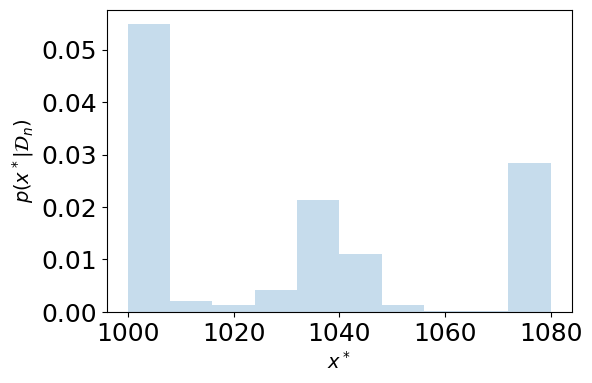

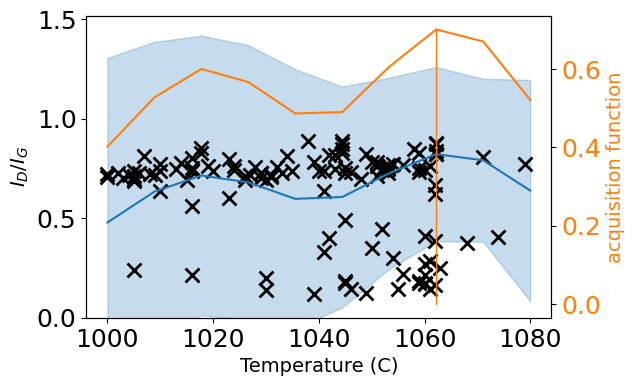

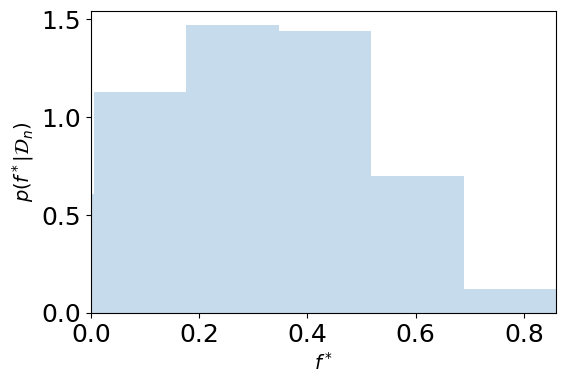

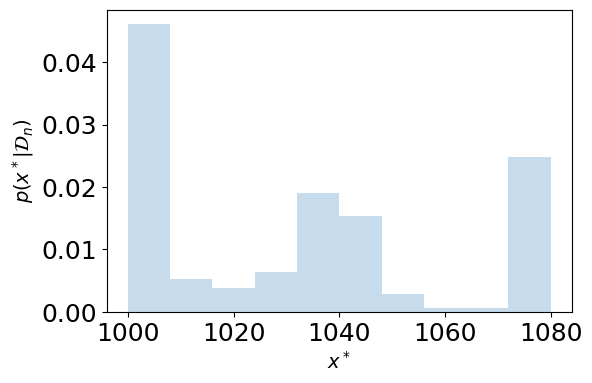

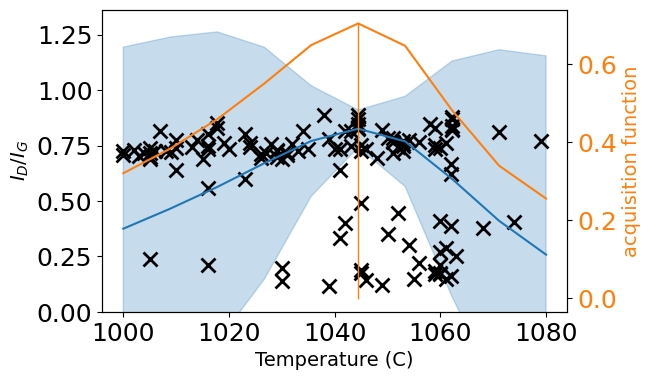

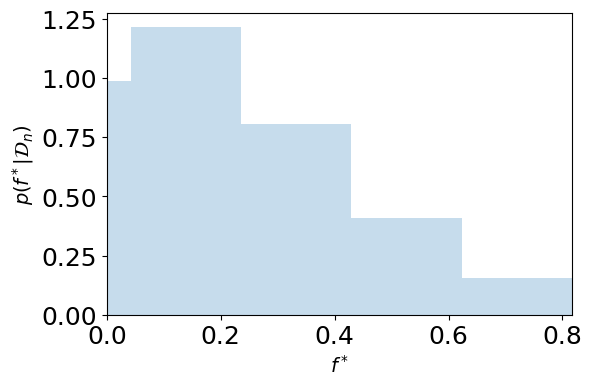

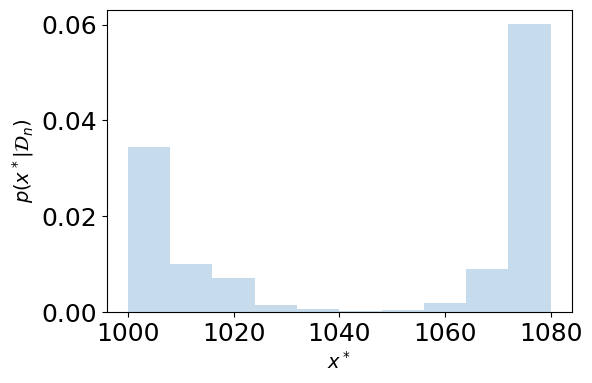

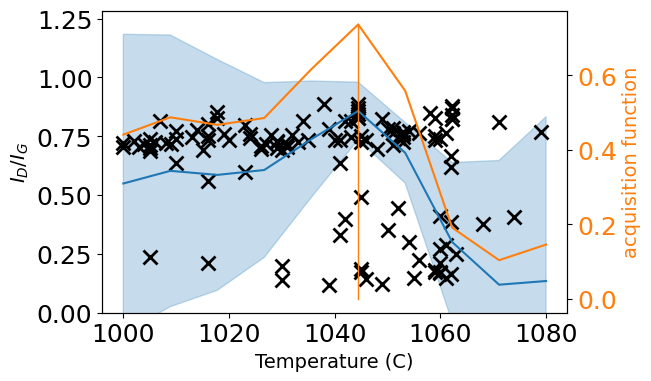

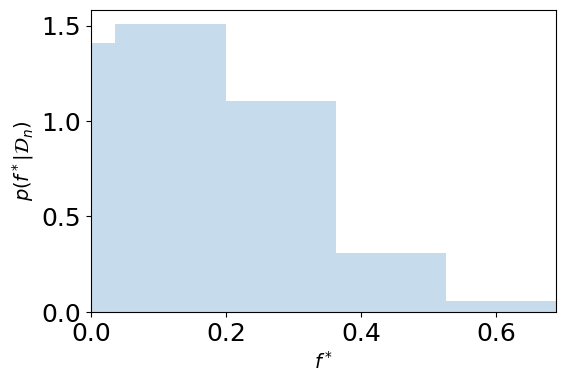

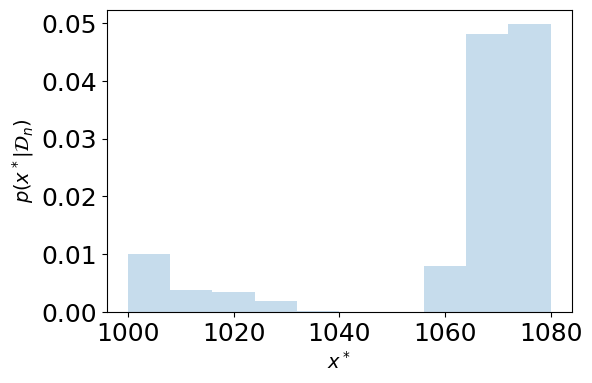

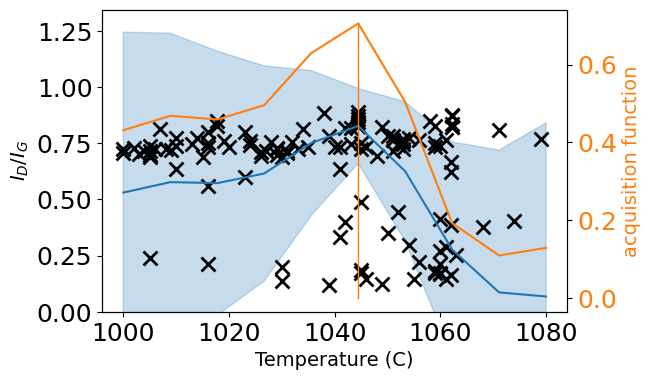

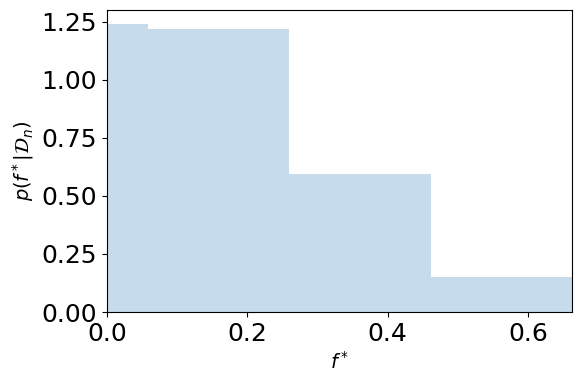

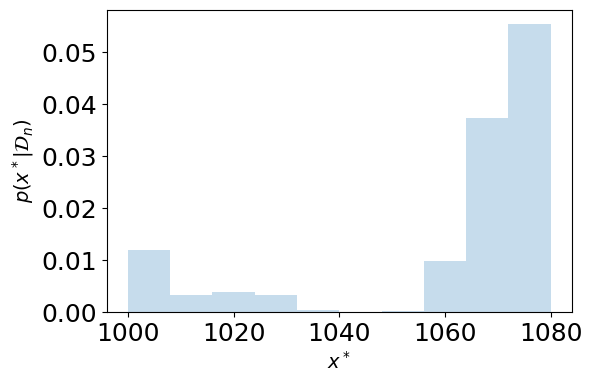

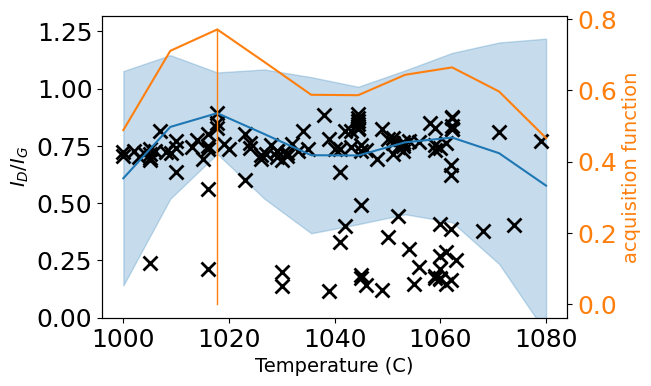

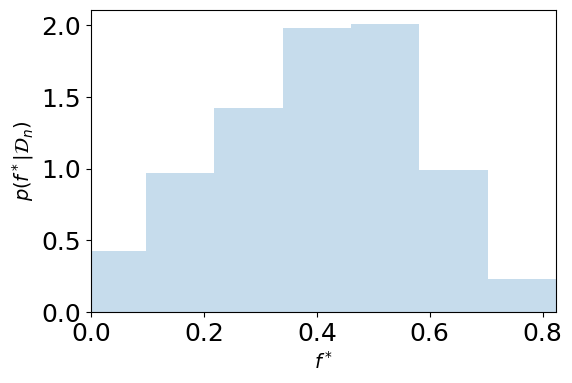

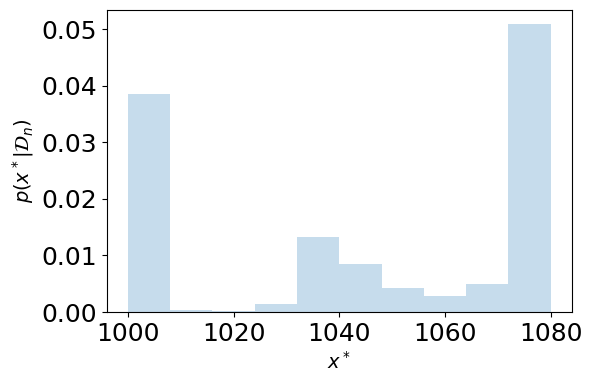

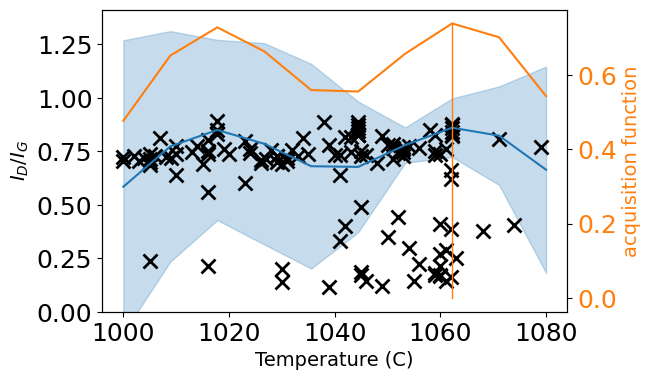

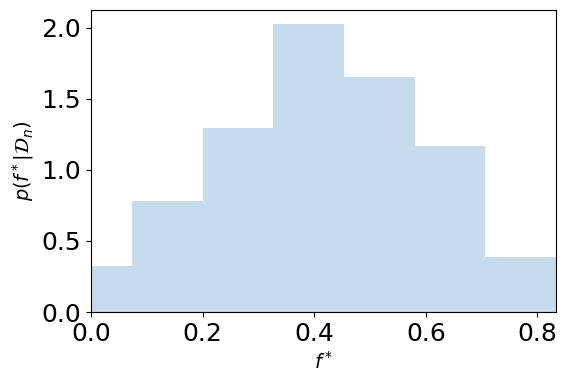

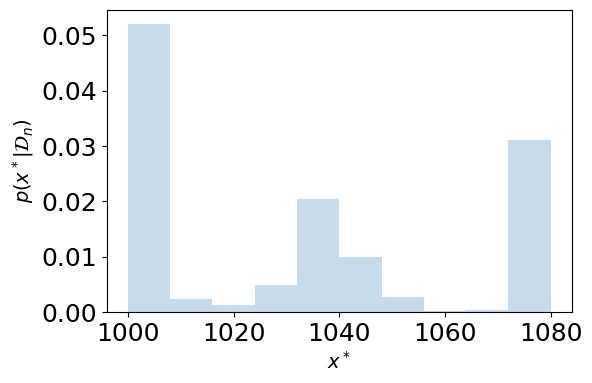

In [ ]:
n = 10
ϵ = 0.7
X_predict = np.zeros((n,d))
X_p = np.zeros((n,d))
X_p[:,0] = np.linspace(1000,1080,n)
X_p[:,1] = np.linspace(5,50,n)
X_p[:,2] = np.linspace(0.1,1,n)
X_p[:,3] = np.linspace(1,10,n)
print(X_p)
# print(X_p)
for p in range(d):
    if p == 0:
        print('p=0')
        for i in range (n):
            for j in range (n):
                for k in range(n):
                    X_predict[:,0] = X_p[:,0]
                    X_predict[:,1] = X_p[i,1]
                    X_predict[:,2] = X_p[j,2]
                    X_predict[:,3] = X_p[k,3]
#                     print(X_predict)
                    mn, v = gp.predict(X_predict)
                    σ = np.sqrt(v - σ_n ** 2)
                    # And you can visualize the results as follows
                    # Standard deviation
                    # Lower quantile
                    l = mn - 2 * σ
                    u = mn + 2 * σ
                    # Sample
                    gp_post_samples = gp.posterior_samples_f(X_predict, 20)[:, 0]
                    # 1D acuisition function
                    af_all = minimize_w_noise_1d(gp, X_predict, p, ϵ, alpha=ei, psi=0., max_it=1)
    elif p == 1:
        print('p=1')
        for i in range (n):
            for j in range (n):
                for k in range(n):
                    X_predict[:,0] = X_p[i,0]
                    X_predict[:,1] = X_p[:,1]
                    X_predict[:,2] = X_p[j,2]
                    X_predict[:,3] = X_p[k,3]
#                     print(X_predict)
                    mn, v = gp.predict(X_predict)
                    σ = np.sqrt(v - σ_n ** 2)
                    # And you can visualize the results as follows
                    # Standard deviation
                    # Lower quantile
                    l = mn - 2 * σ
                    u = mn + 2 * σ
                    # Sample
                    gp_post_samples = gp.posterior_samples_f(X_predict, 20)[:, 0]
                    # 1D acuisition function
                    af_all = minimize_w_noise_1d(gp, X_predict, p, ϵ, alpha=ei, psi=0., max_it=1)
                            
    elif p == 2:
        print('p=2')
        for i in range (n):
            for j in range (n):
                for k in range(n):
                    X_predict[:,0] = X_p[i,0]
                    X_predict[:,1] = X_p[j,1]
                    X_predict[:,2] = X_p[:,2]
                    X_predict[:,3] = X_p[k,3]
 #                     print(X_predict)
                    mn, v = gp.predict(X_predict)
                    σ = np.sqrt(v - σ_n ** 2)
                    # And you can visualize the results as follows
                    # Standard deviation
                    # Lower quantile
                    l = mn - 2 * σ
                    u = mn + 2 * σ
                    # Sample
                    gp_post_samples = gp.posterior_samples_f(X_predict, 20)[:, 0]
                    # 1D acuisition function
                    af_all = minimize_w_noise_1d(gp, X_predict, p, ϵ, alpha=ei, psi=0., max_it=1)
    else:
        print('p=3')
        for i in range (n):
            for j in range (n):
                for k in range(n):
                    X_predict[:,0] = X_p[i,0]
                    X_predict[:,1] = X_p[j,1]
                    X_predict[:,2] = X_p[k,2]
                    X_predict[:,3] = X_p[:,3]
#                     print(X_predict)
                    mn, v = gp.predict(X_predict)
                    σ = np.sqrt(v - σ_n ** 2)
                    # And you can visualize the results as follows
                    # Standard deviation
                    # Lower quantile
                    l = mn - 2 * σ
                    u = mn + 2 * σ
                    # Sample
                    gp_post_samples = gp.posterior_samples_f(X_predict, 20)[:, 0]
                    # 1D acuisition function
                    af_all = minimize_w_noise_1d(gp, X_predict, p, ϵ, alpha=ei, psi=0., max_it=1)

References:

[39] Bilionis, I. Introduction to Uncertainty (2018). URL https://github.com/PredictiveScienceLab/uq-course.